# 0.0. IMPORTS

In [2]:
import math
import inflection
import datetime

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt


from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from IPython.core.display  import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from boruta                import BorutaPy

from scipy                import stats           as ss
from sklearn              import model_selection as ms

## 0.1. Helper Funcitions

In [3]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))
    


In [4]:
jupyter_settings()

## 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

#dividindo em treino e teste
df_train, df_test = ms.train_test_split(df_raw, test_size = 0.2, random_state=0 )

In [6]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
632098,679,4,2013-12-12,9628,1029,1,0,0,0,a,a,4140.0,9.0,2012.0,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS

In [7]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
           'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Rows: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Rows: 18


## 1.3. Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA (aula 06)

In [12]:
df1['competition_distance'].max()

75860.0

In [13]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Set', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis= 1)

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [15]:
df1.sample(5).T

,483333,134824,412678,89929,29852
store,209,1025,914,730,863
day_of_week,4,4,5,2,7
date,2014-04-24 00:00:00,2015-04-02 00:00:00,2014-06-27 00:00:00,2015-05-12 00:00:00,2015-07-05 00:00:00
sales,5264,10000,8010,5936,2616
customers,587,1111,968,802,331
open,1,1,1,1,1
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,1,0,0,0
store_type,a,a,c,c,a


## 1.6. Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kustosis']
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


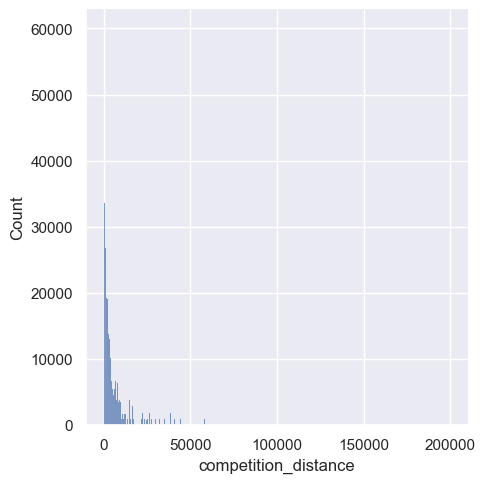

In [20]:
sns.displot(df1['competition_distance'])

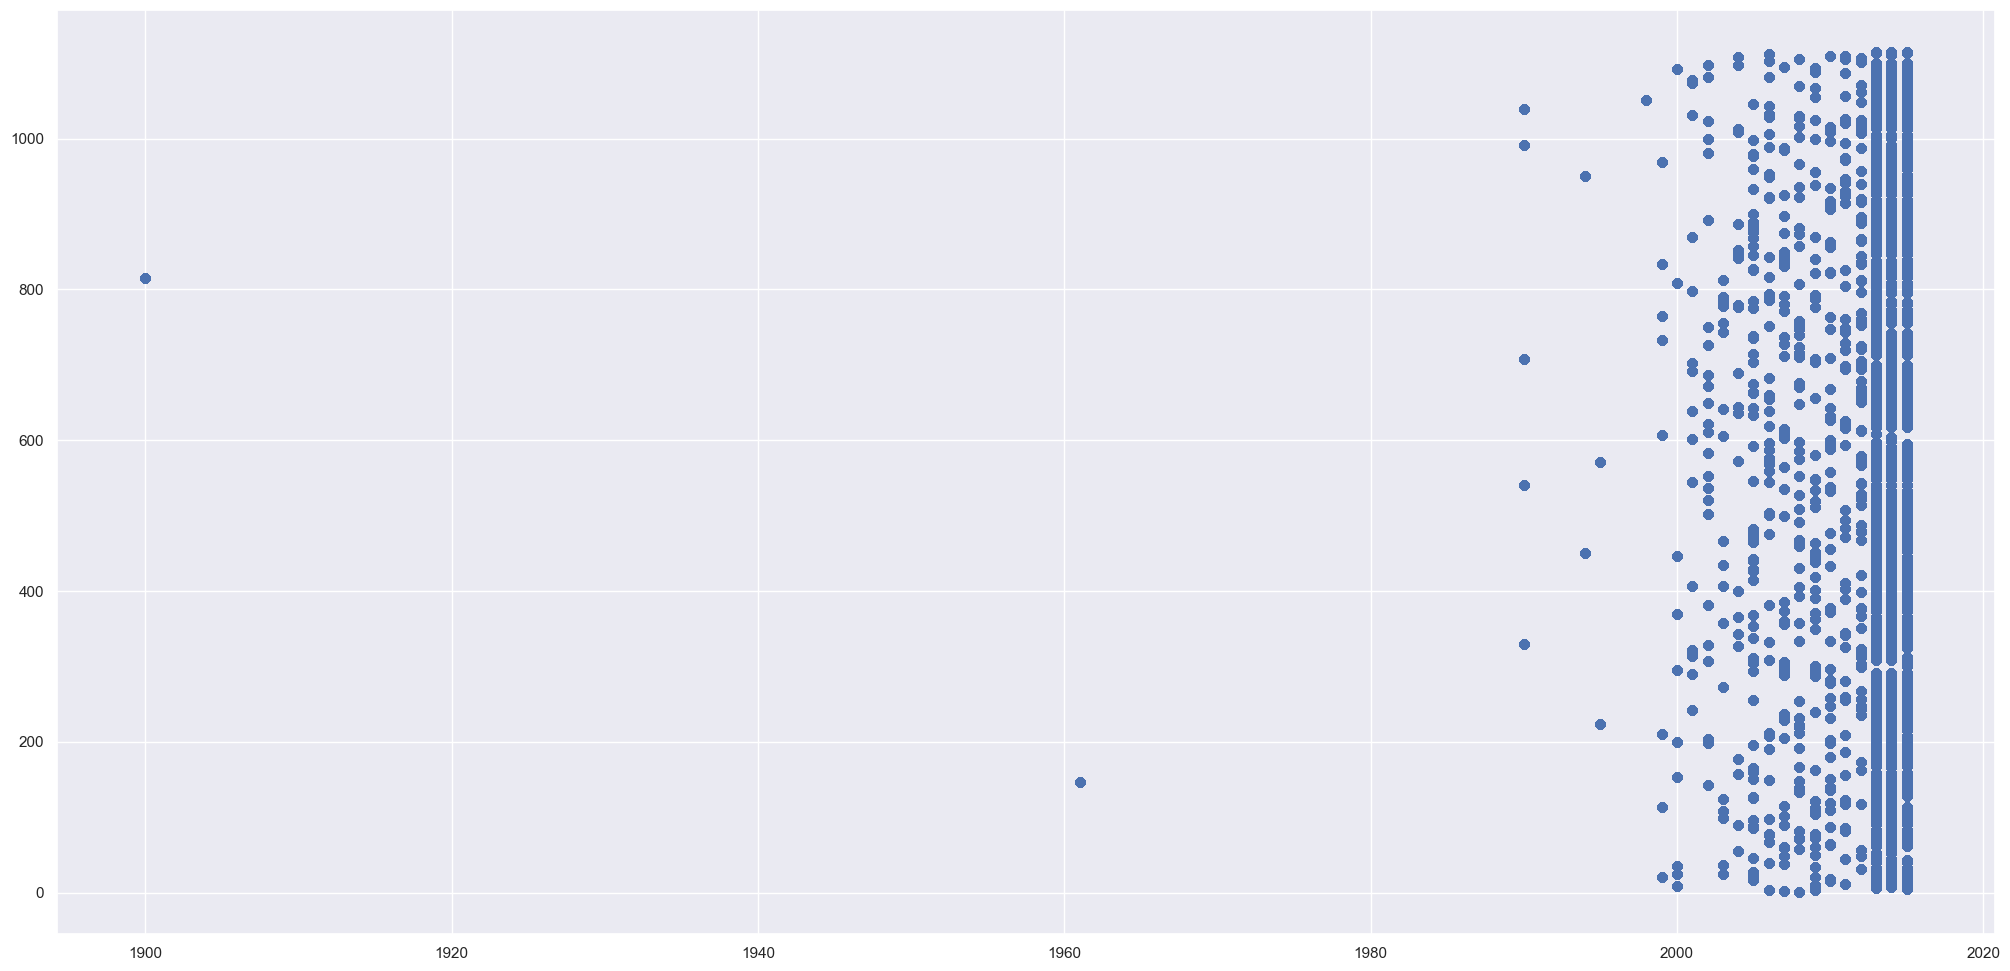

In [21]:
plt.scatter(df1['competition_open_since_year'],df1['store'])

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

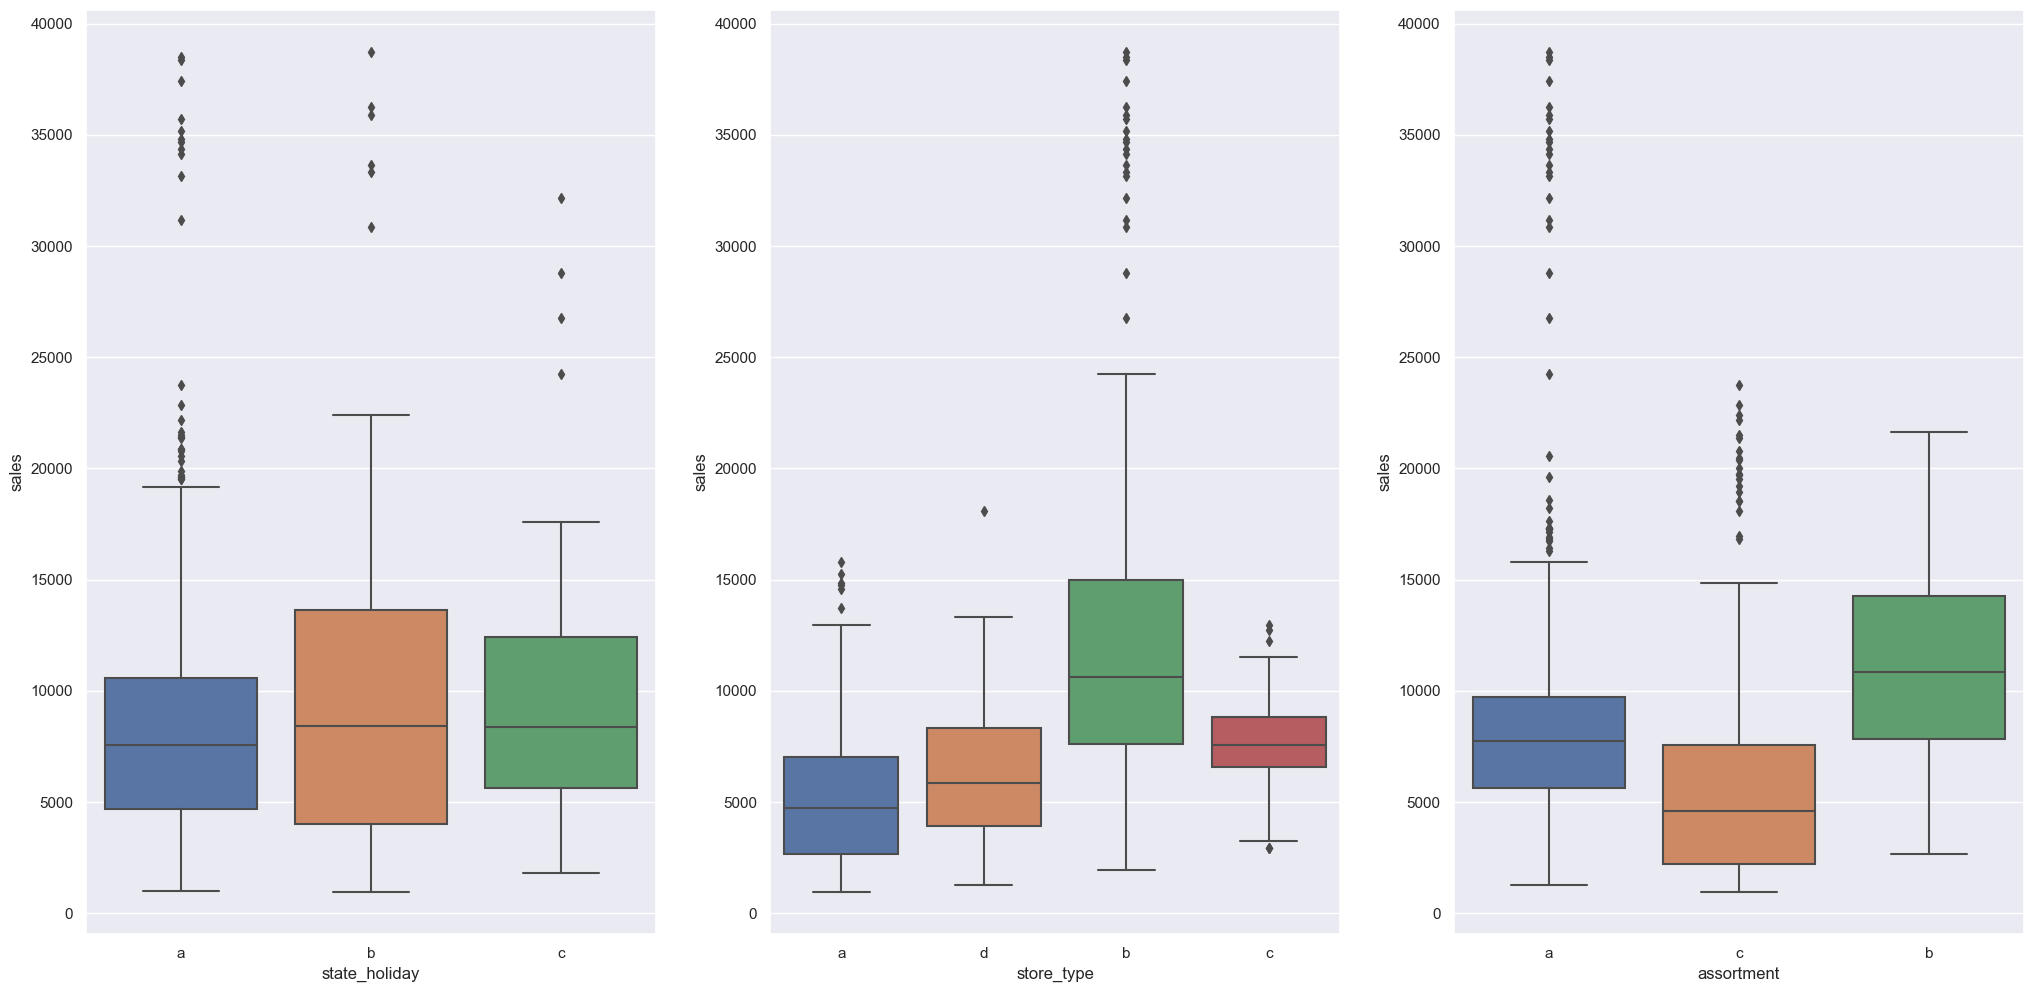

In [23]:
aux1 = df1 [(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

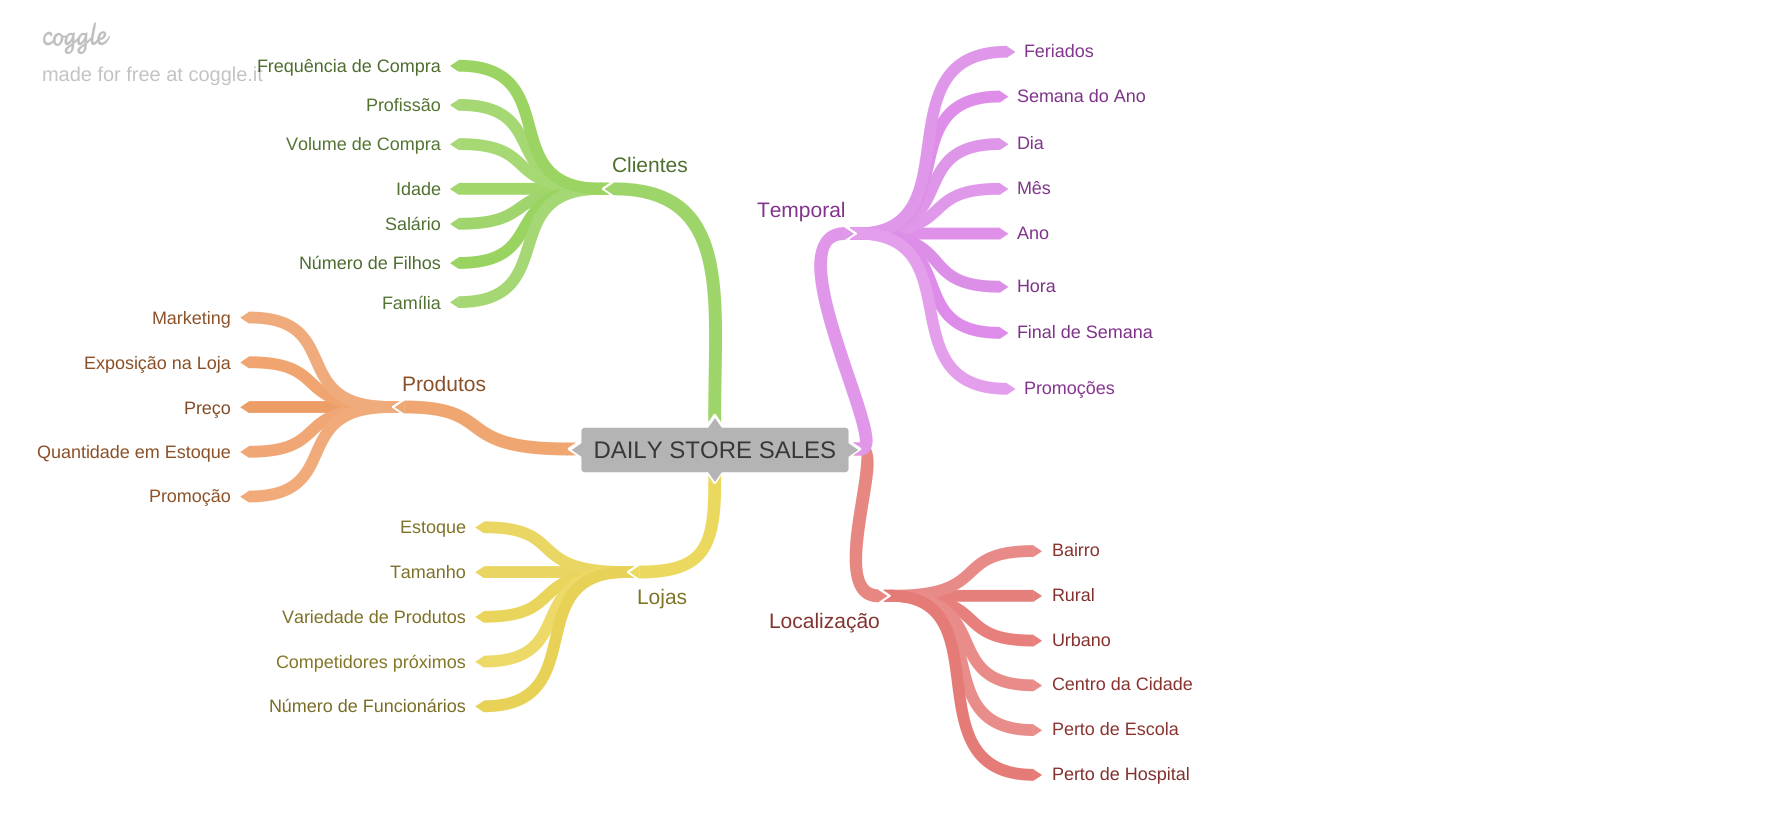

In [25]:
Image('img/MindMapHypothesis.png')

## 2.2. Criação das Hipoteses

### 2.2.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionário deveriam vender mais.

**2.** Lojas com maior estoque deveria vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior varidade deveriam vender mais.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas que tem preços menores no produtos deveriam vender mais.

**4.** Lojas com promoções com mais desconto deveriam vender mais.

**5.** Lojas com tempo maior tempo de promoção deveriam vender mais.

**6.** Lojas que tem preços menores por mais tempos nos produtos deveriam vender mais.

**7.** Lojas que fazem mais promoção vendem mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o Natal deveriam vender mais.

**2.** Lojas que abrem segundo semestre deveriam vender mais.

**3.** Lojas deveriam vender menos aos finais de semana.

**4.** Lojas que tem o horário de atendimento maior deveriam vender mais.

**5.** Lojas que ficam mais tempo com promoções deveriam vender mais.

**6.** Lojas deveriam vender mais depois do dia 10 de cada mês.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior variedade deveriam vender mais.

**2.** Lojas com competidores à mais tempo deveriam vender mais.

**3.** Lojas com competidores mais próximos deveria vender menos.

**4.** Lojas com tempo maior tempo de promoção deveriam vender mais.

**5.** Lojas que fazem mais promoção vendem mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o Natal deveriam vender mais.

**8.** Lojas que abrem segundo semestre deveriam vender mais.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender mais ao longo dos anos.

**12.** Lojas deveriam vender menos durantes os feriados escolares.

## 2.4. Feature Engineering

In [26]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competition since
df2['competition_since'] = (df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                  month=x['competition_open_since_month'], 
                                                                  day=1), axis=1))
df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) /30)
                                 .apply(lambda x: x.days)
                                 .astype('int64'))

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = (df2['promo_since']
                      .apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)))

df2['promo_time_week'] = (((df2['date'] - df2['promo_since']) /7)
                          .apply(lambda x: x.days)
                          .astype(int))

#assortment
df2['assortment'] = (df2['assortment'].apply(lambda x: 'basic' if x == 'a' 
                                             else 'extra' if x == 'b' 
                                             else 'extended'))

#state holiday
df2['state_holiday'] = (df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                   else 'easter_holiday' if x == 'b' 
                                                   else 'christmas' if x == 'c' 
                                                   else 'regular_day'))


In [27]:
df2['week_of_year'] = df2['week_of_year'].astype('int64')
df2['promo_time_week'] = df2['promo_time_week'].astype('int64')

In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [29]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0. FILTRAGEM DE VARIÁVEIS

In [30]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

df3 = df3[(df3['competition_open_since_year'] > 1972)]

## 3.2. Seleção das Colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS - EDA

In [34]:
df4 = df3.copy()

## 4.1. Análise Univariade

### 4.1.1. Response Variable

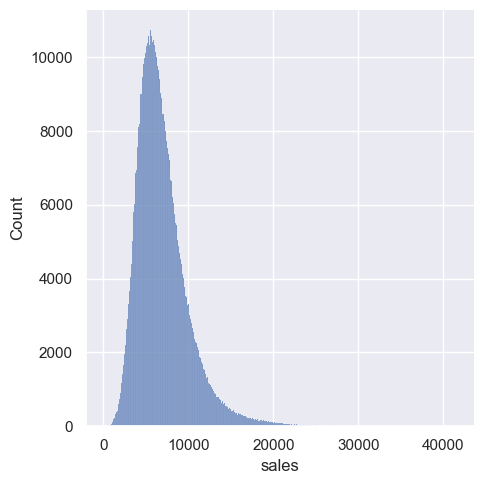

In [35]:
sns.displot(df4['sales'])

### 4.1.2. Numerical Variable

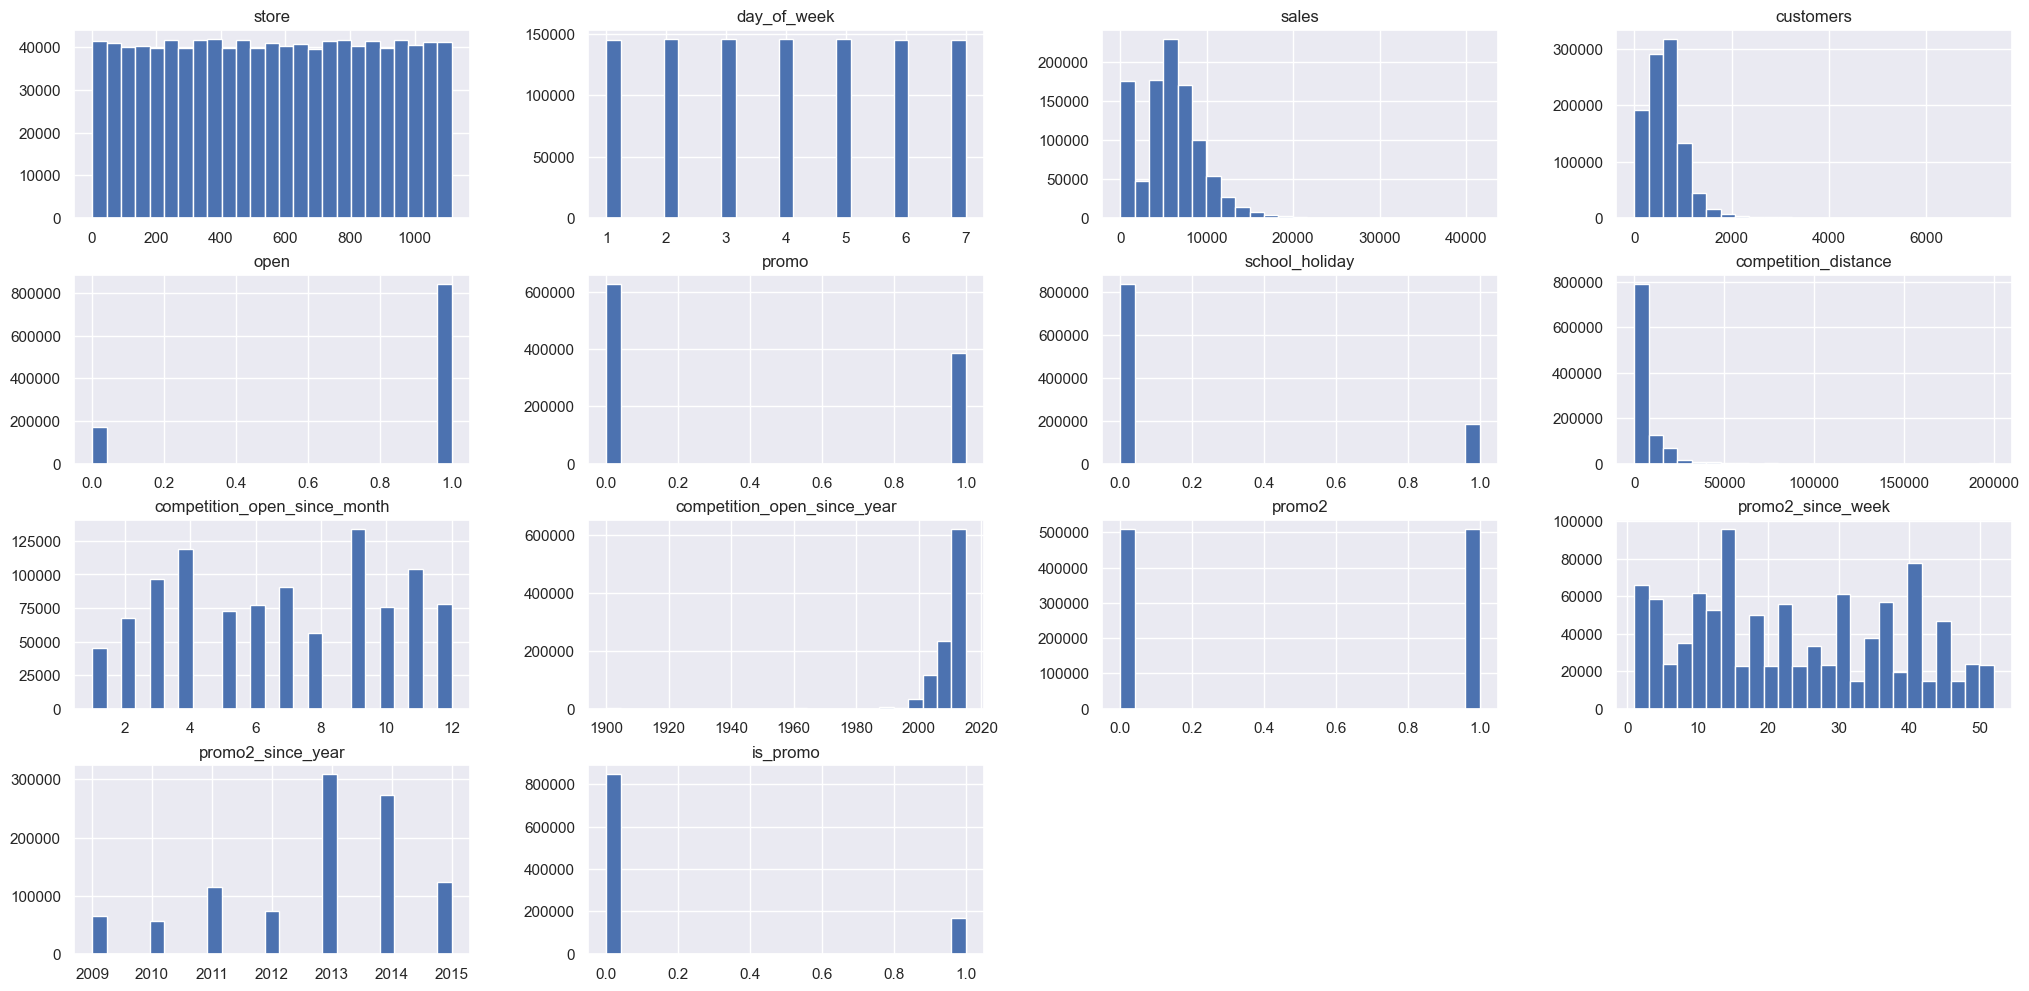

In [36]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

<AxesSubplot: xlabel='sales', ylabel='Density'>

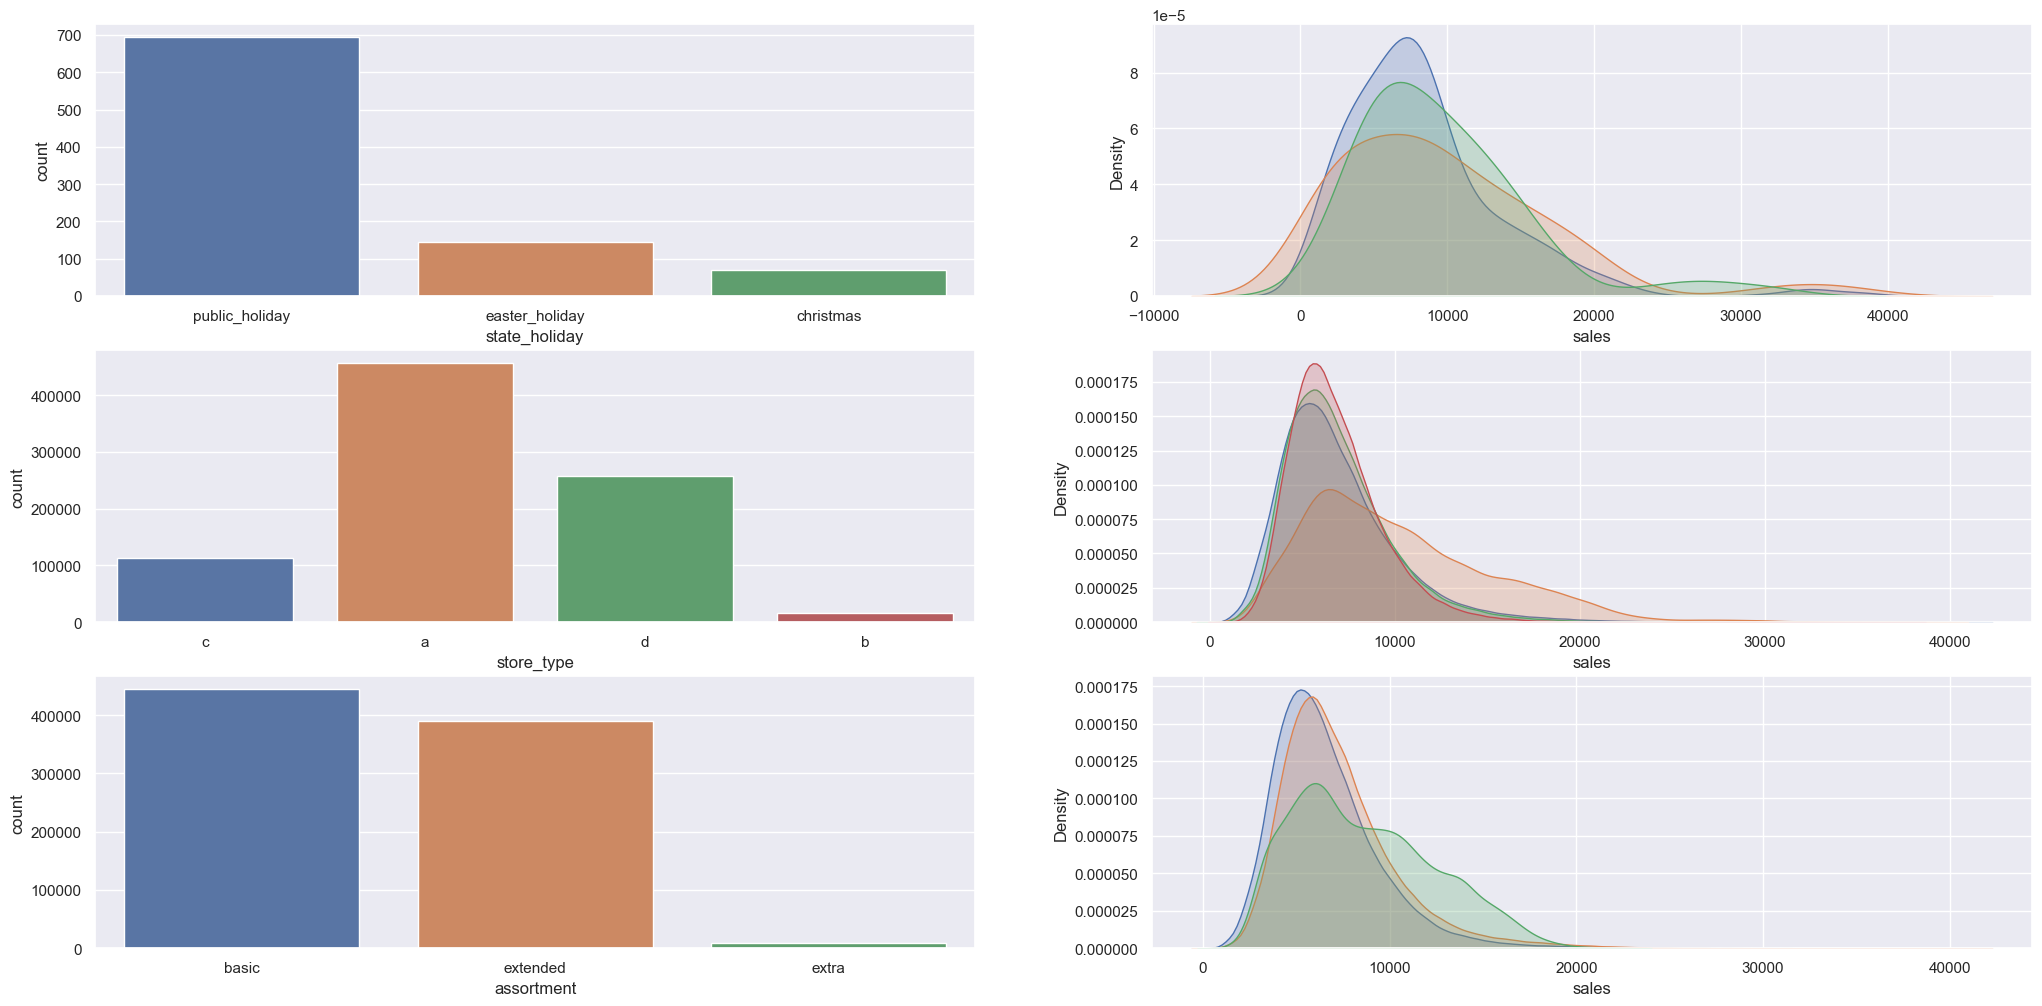

In [37]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

## 4.2. Análise Bivariada

### H1. Lojas com maior variedade deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS


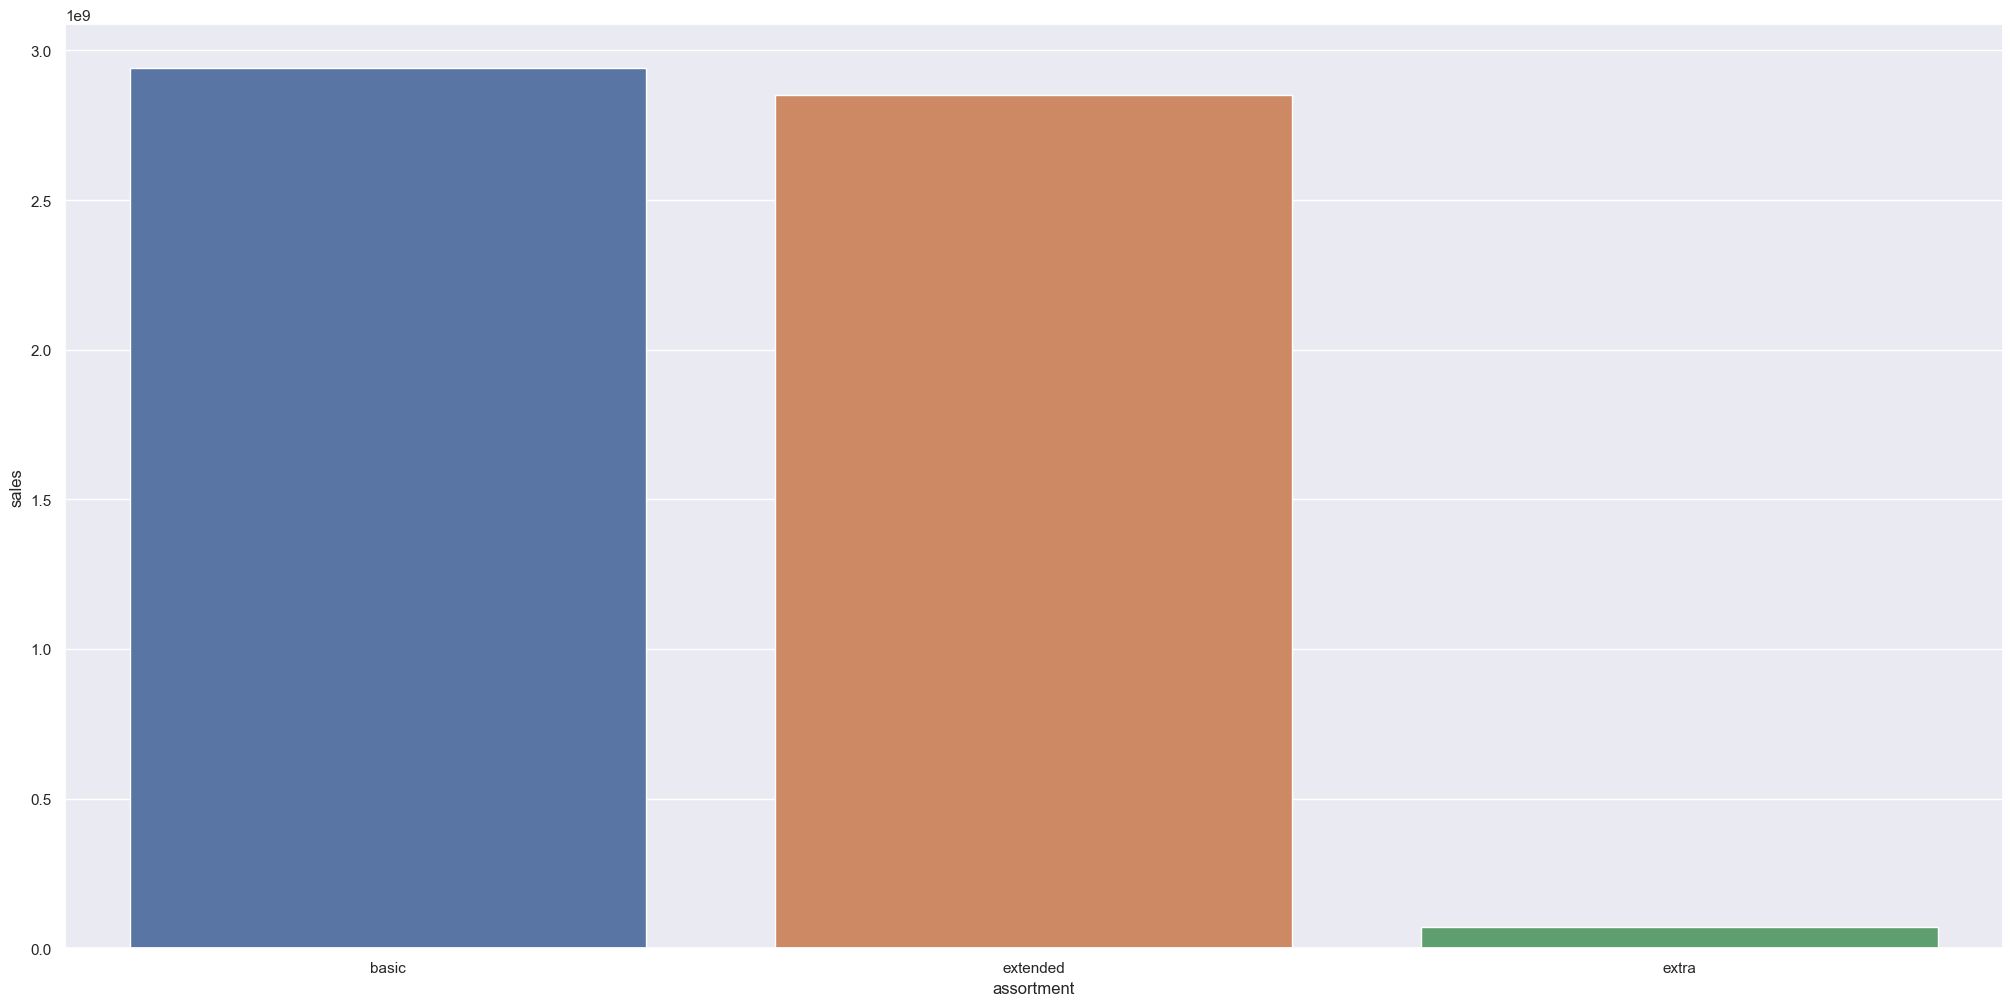

In [38]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

<AxesSubplot: xlabel='year_week'>

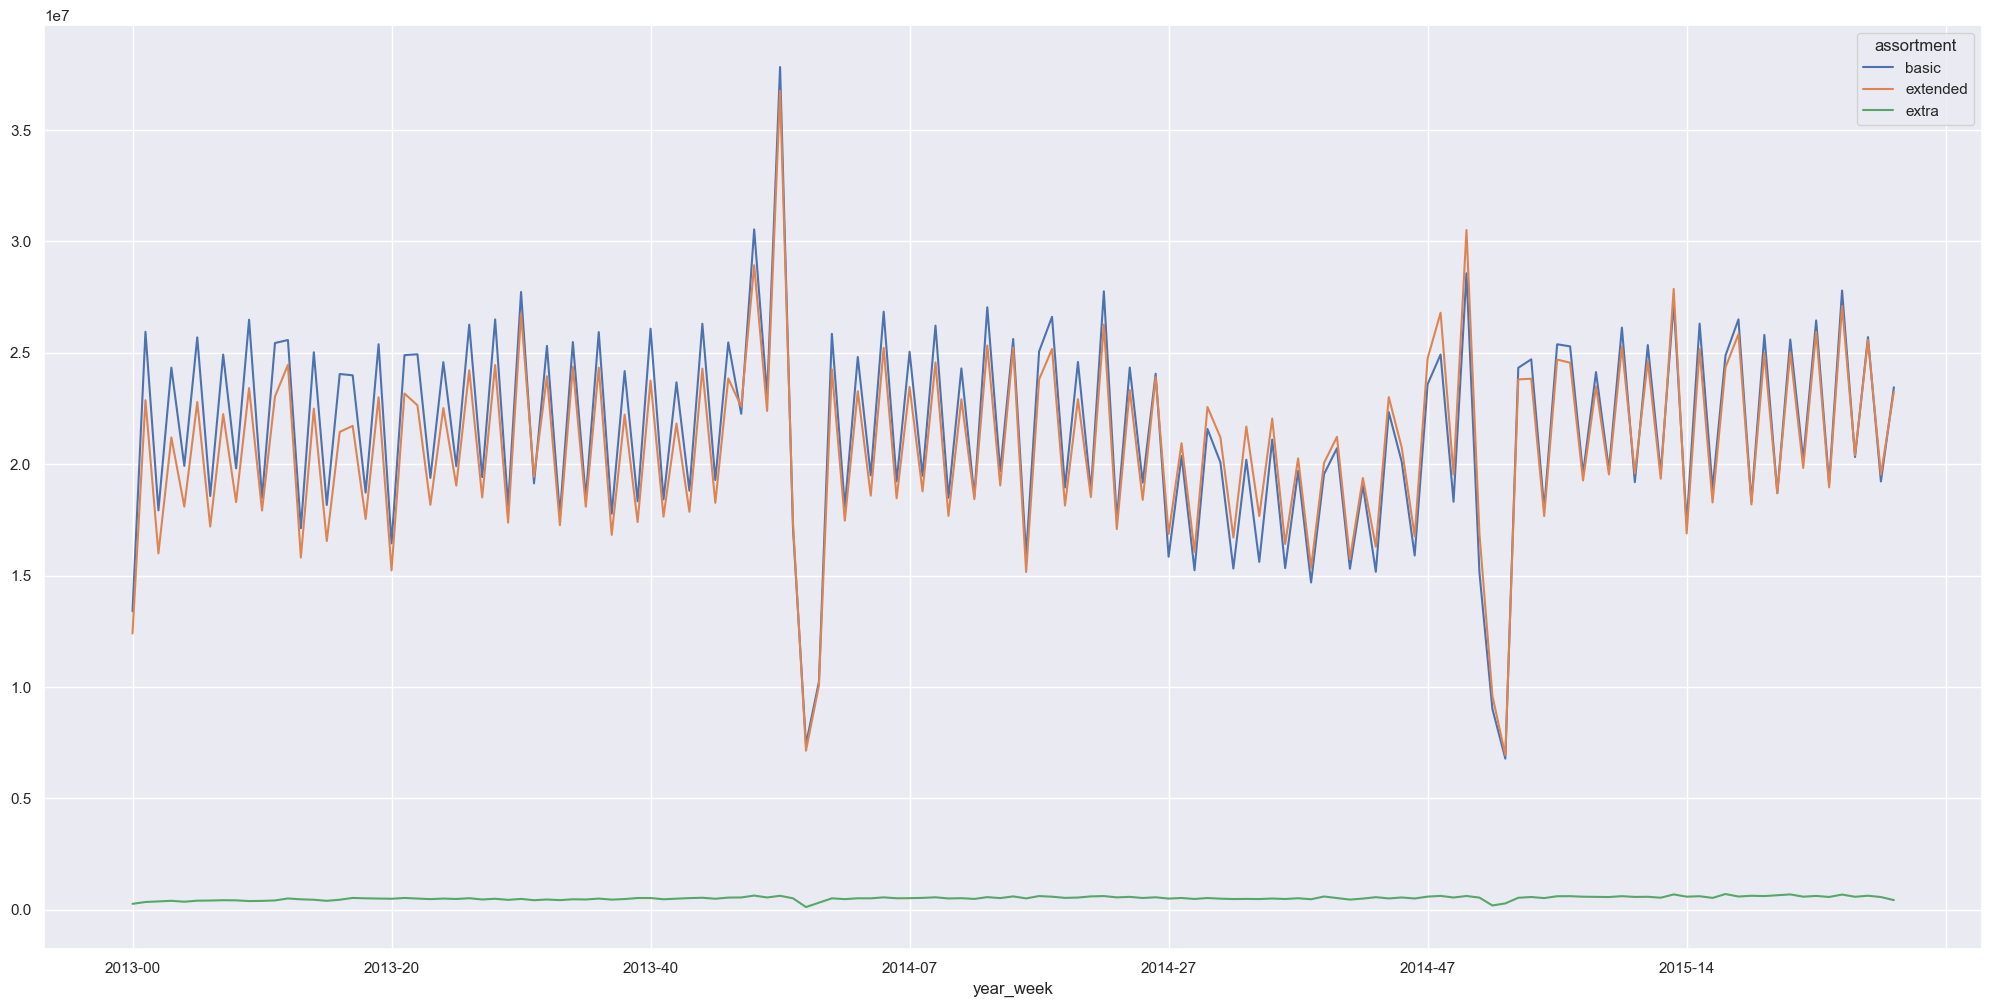

In [39]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

<AxesSubplot: xlabel='year_week'>

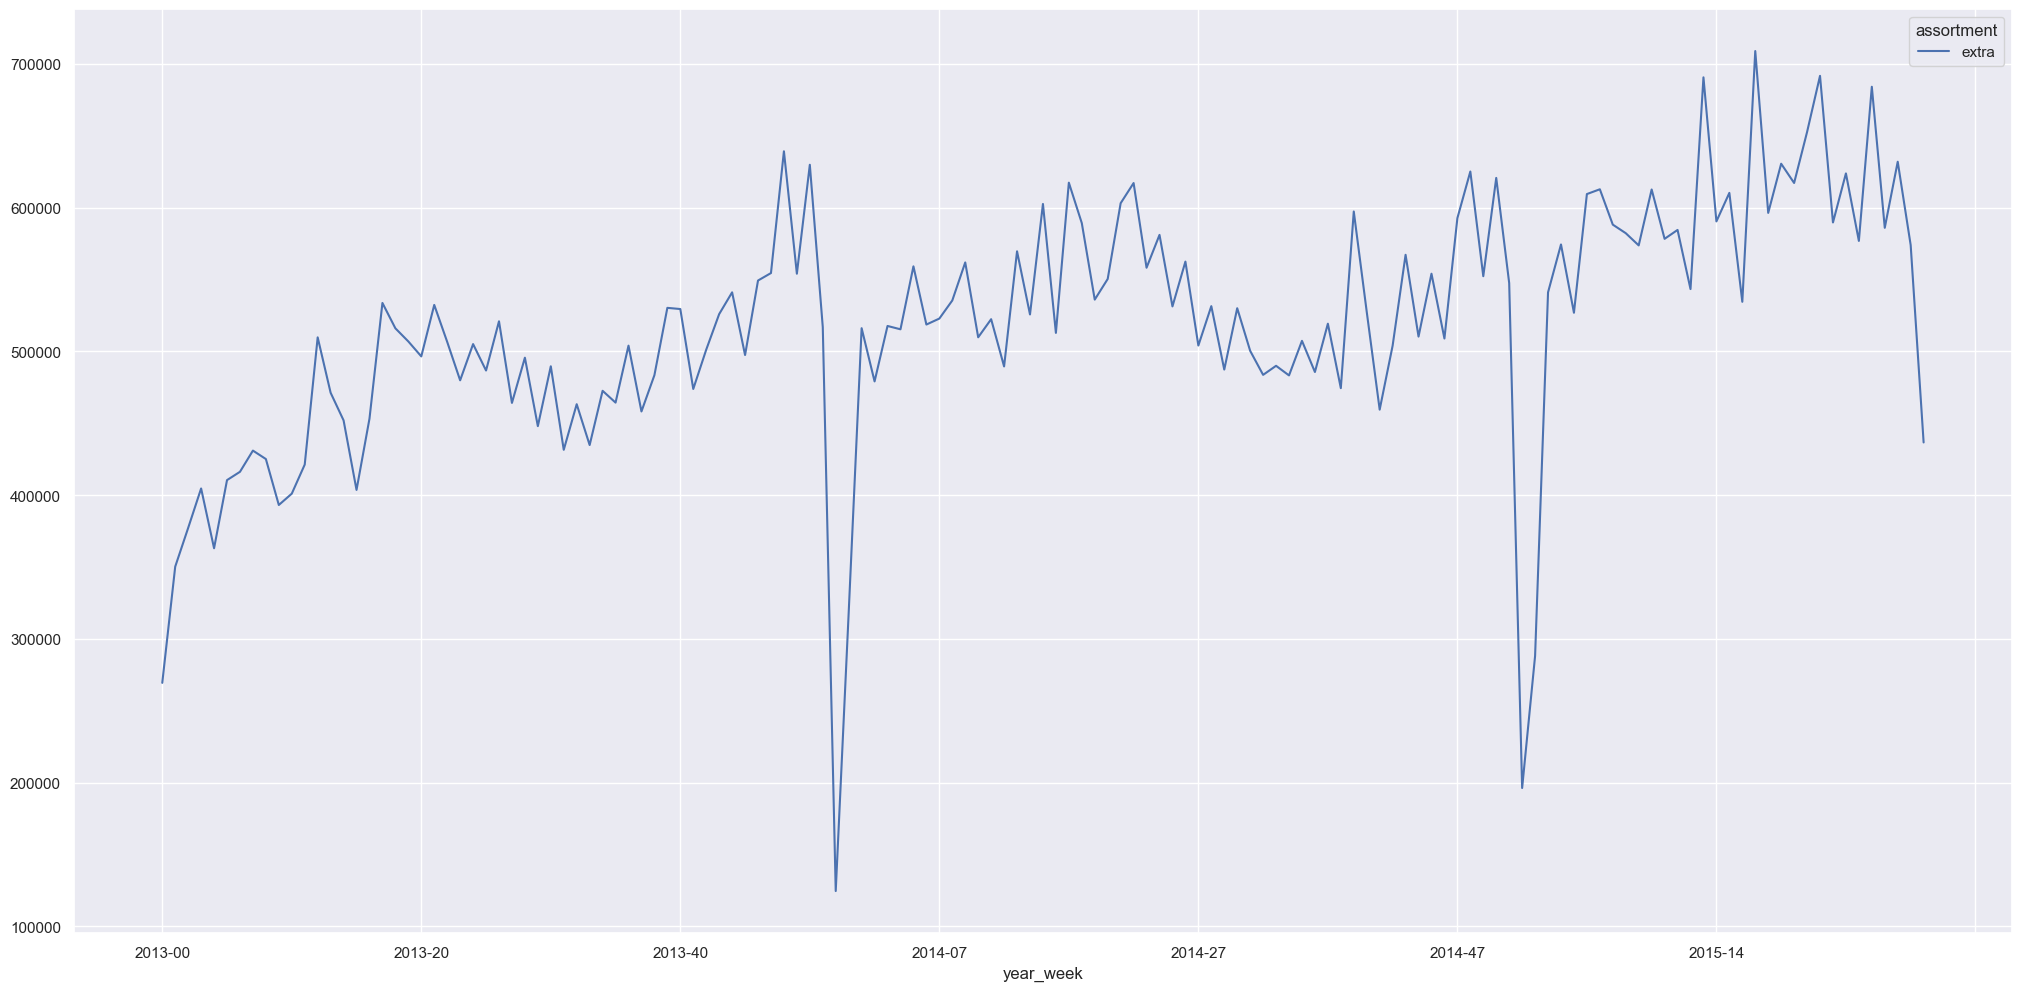

In [40]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

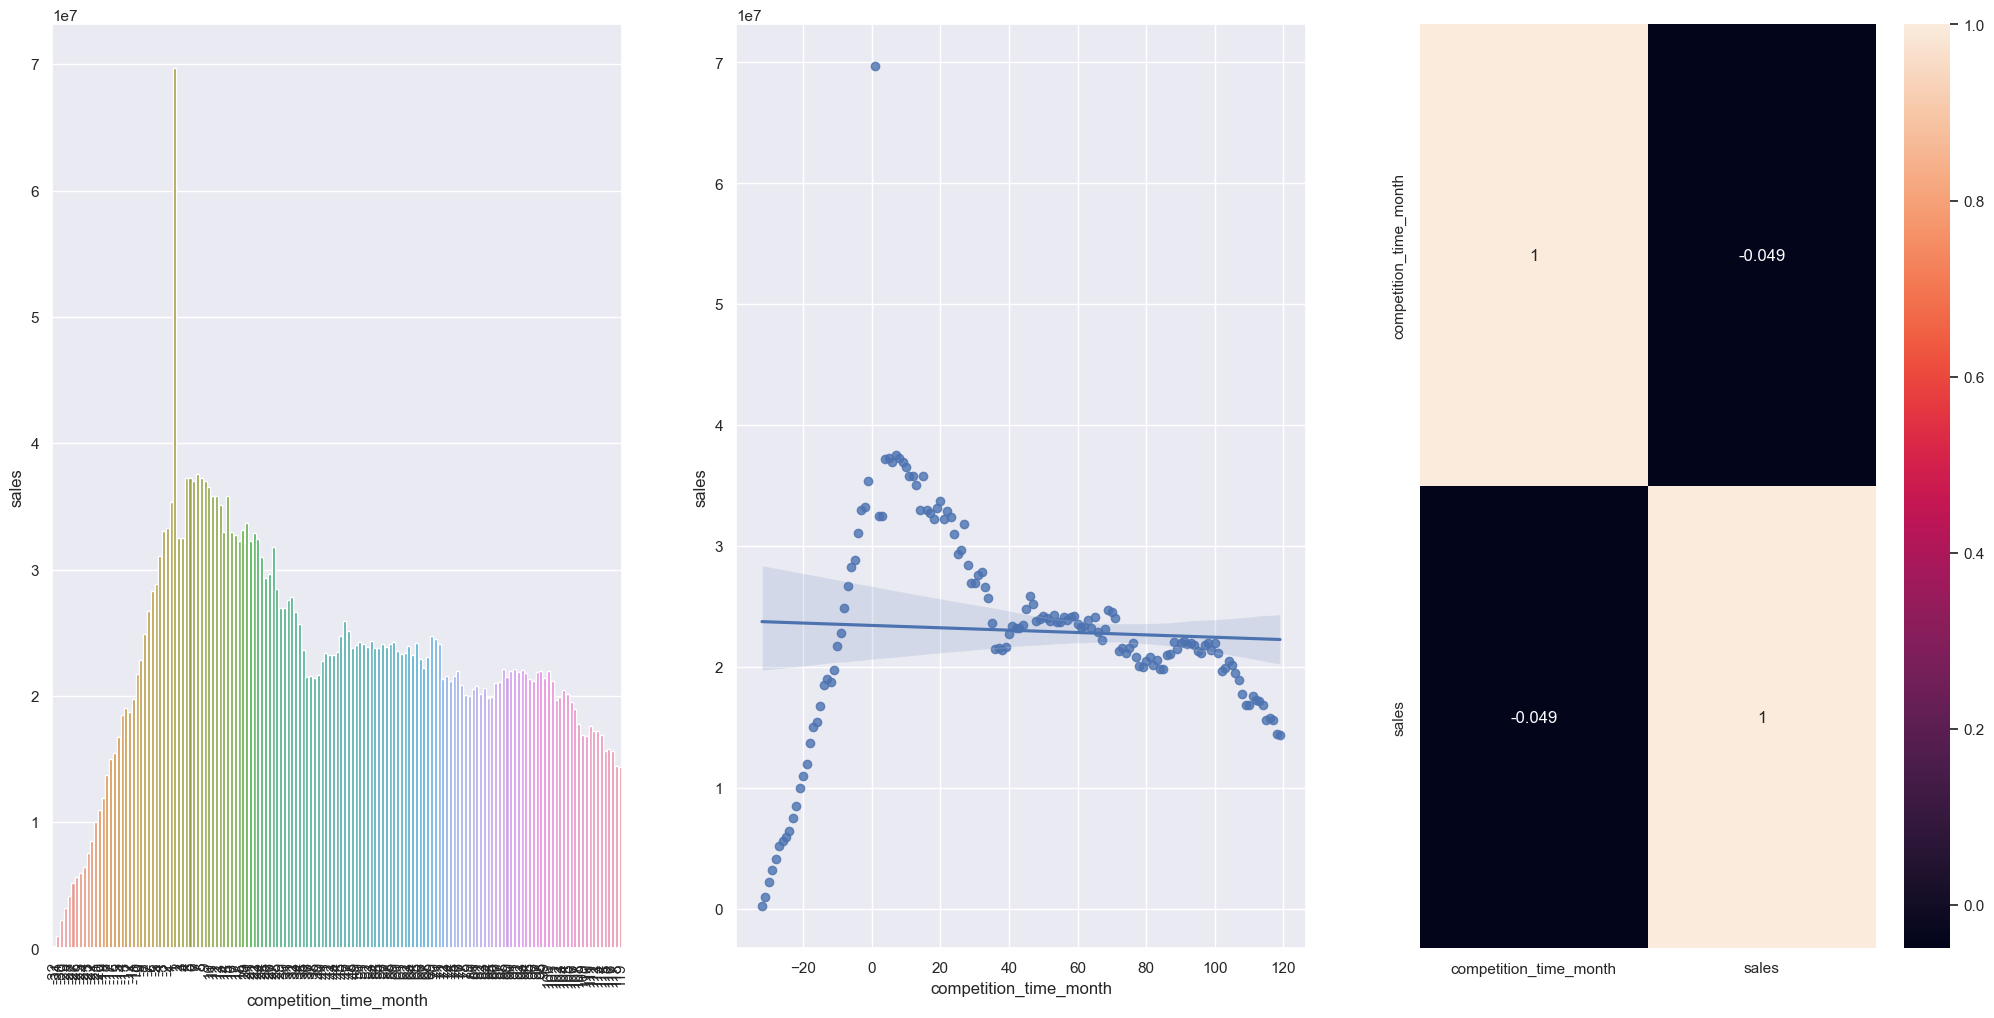

In [41]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### H3. Lojas com competidores mais próximos deveria vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

C:\Users\ADM\AppData\Local\Temp\ipykernel_1460\3098859081.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


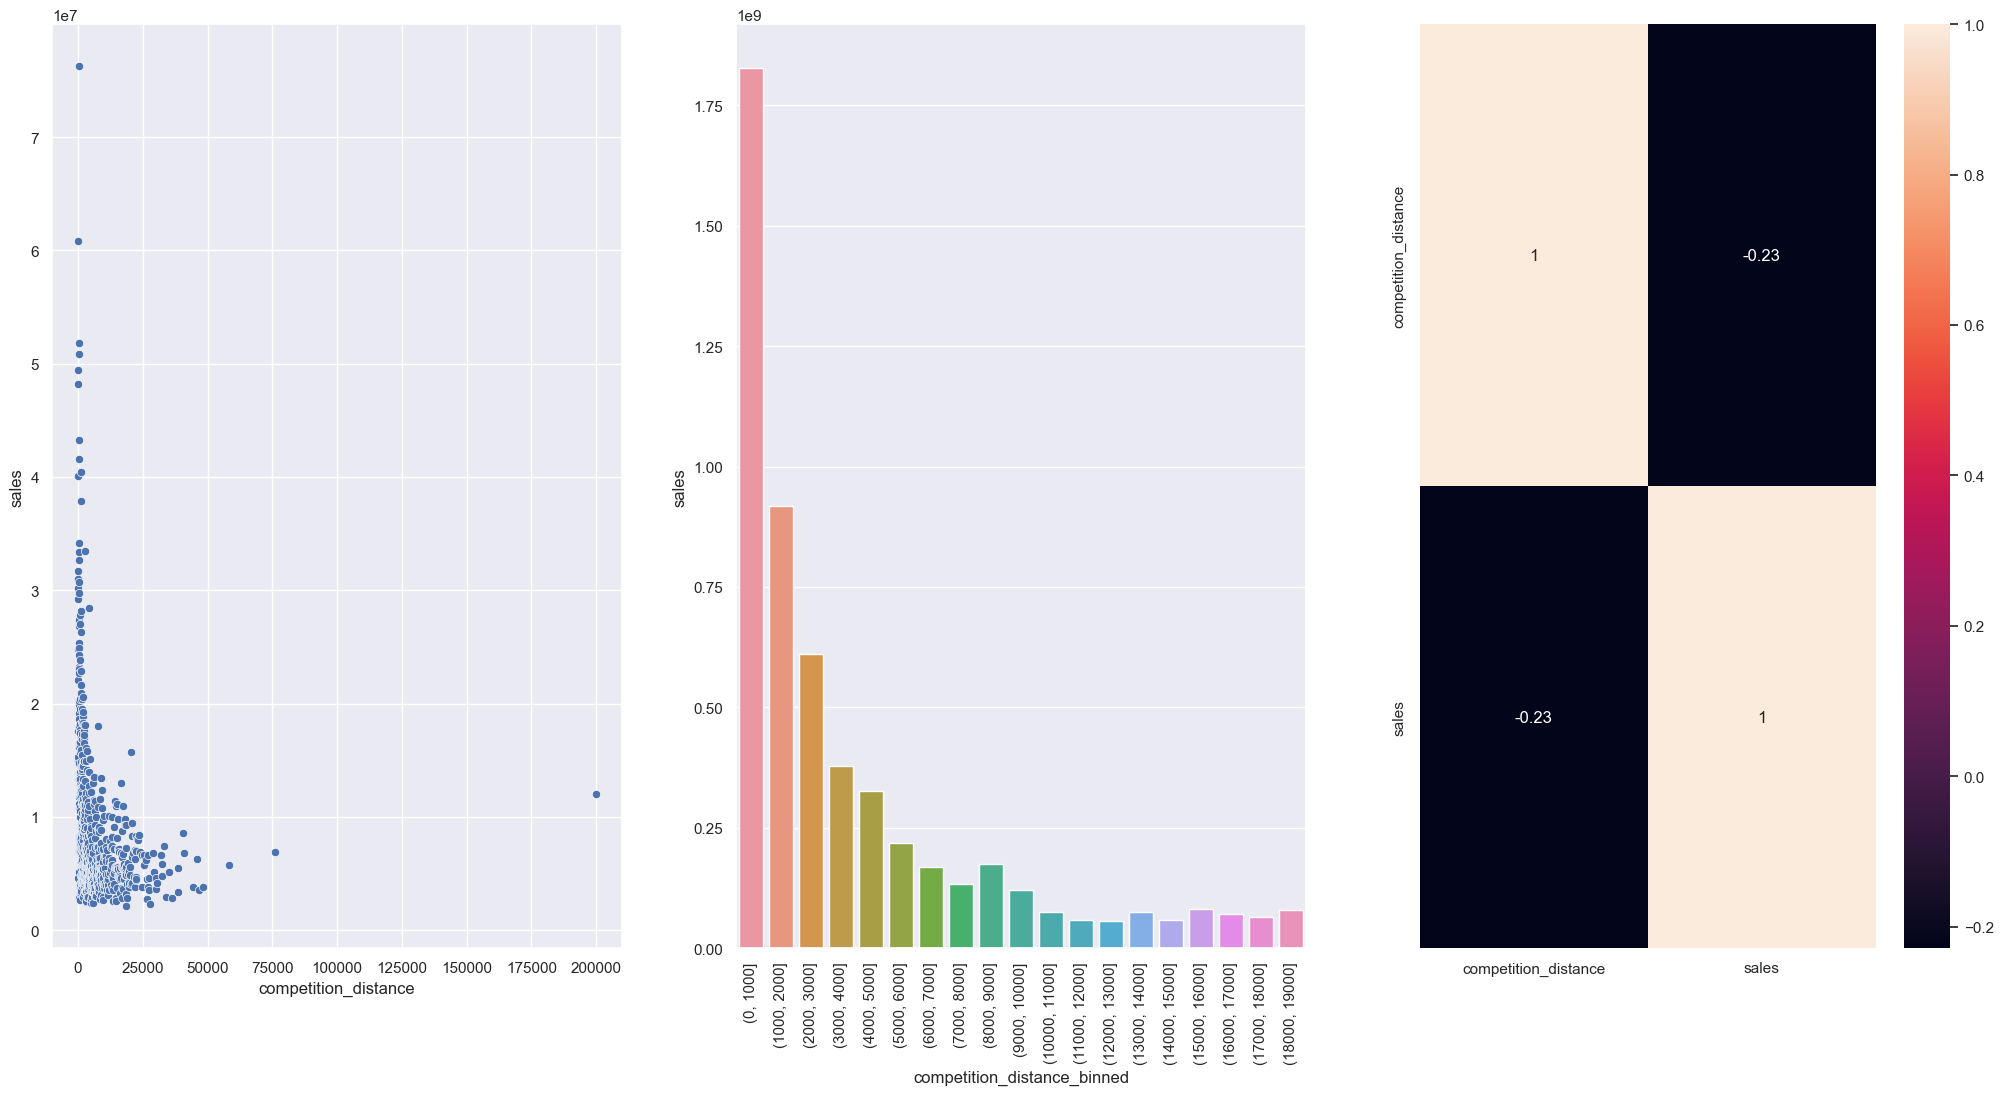

In [42]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4. Lojas com tempo maior tempo de promoção deveriam vender mais.
**FALSA** Lojas com TEMPO MAIOR de promoção vendem MENOS, depois de um certo período de promoção.


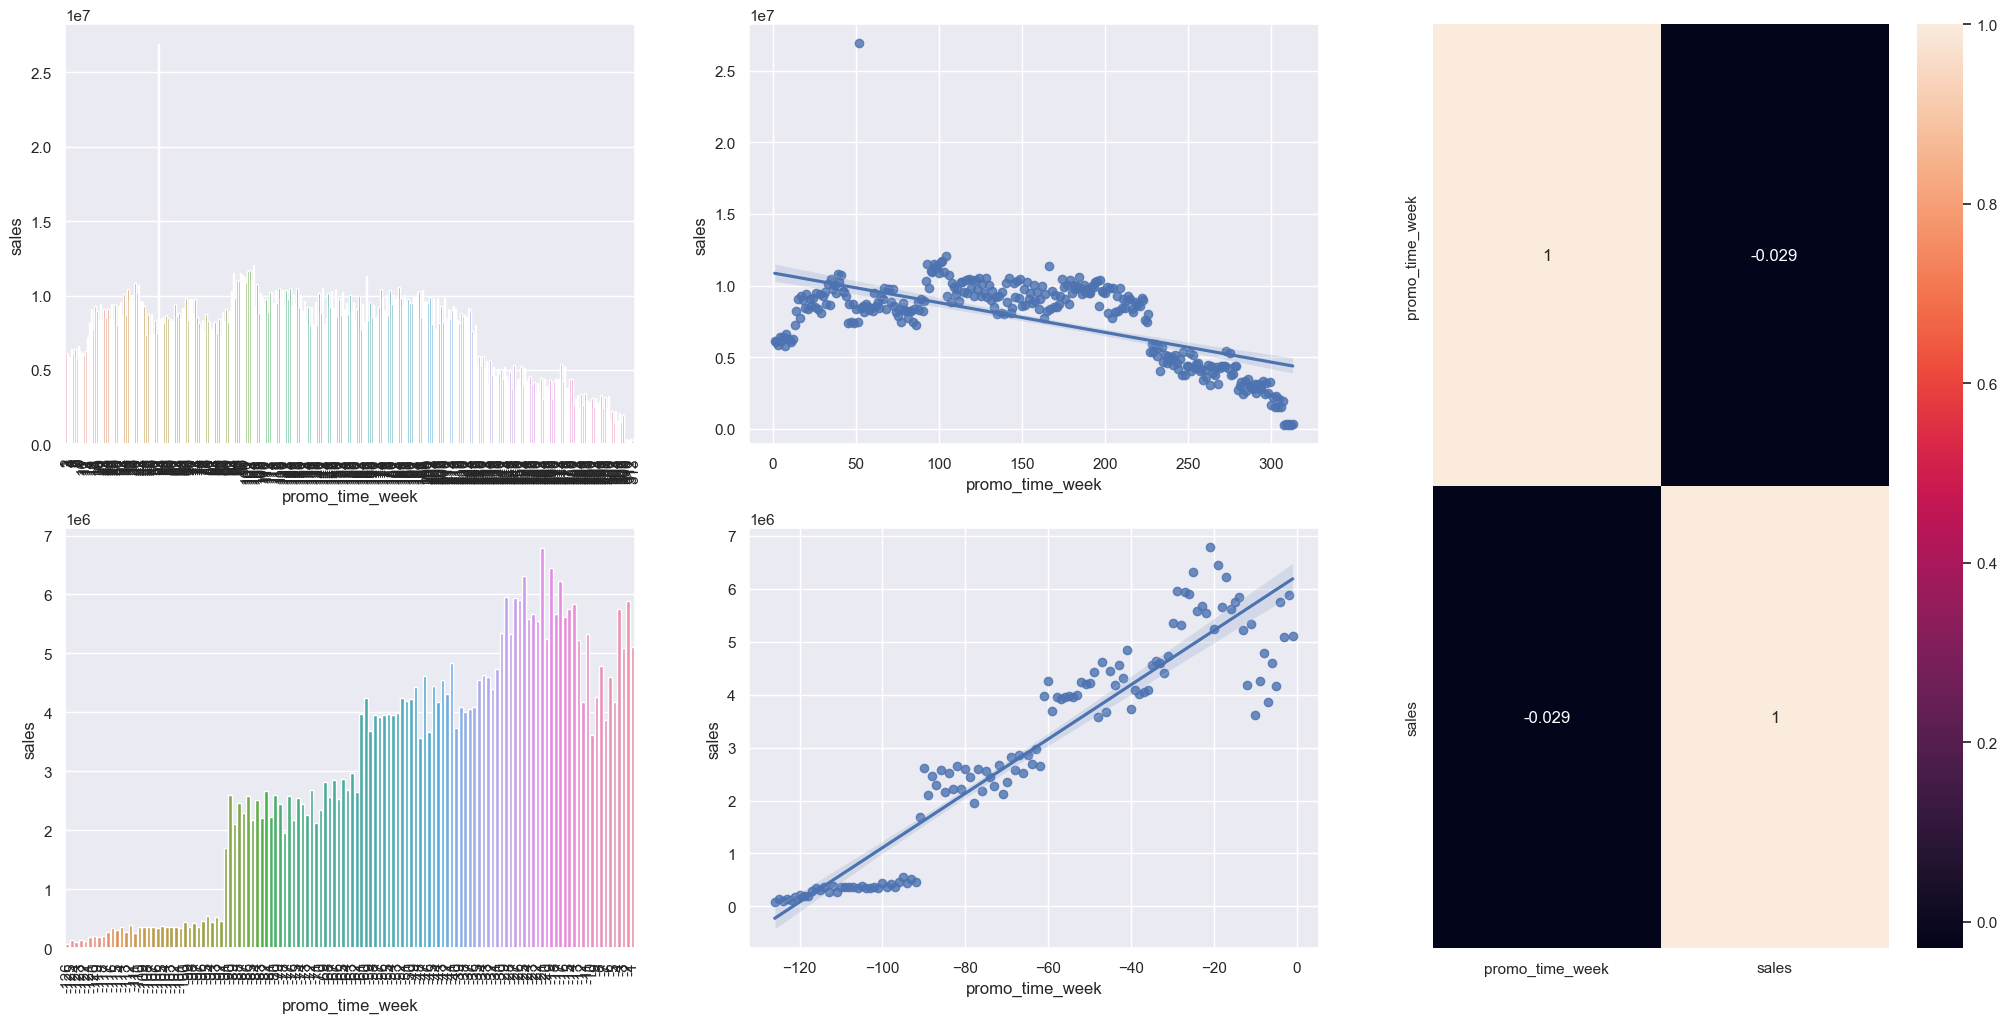

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);


plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

 ### <s> H5. Lojas que fazem mais promoção vendem mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais. (aula 14 - 26:30)
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1283940737
2,1,0,1628930532
3,1,1,1466388852


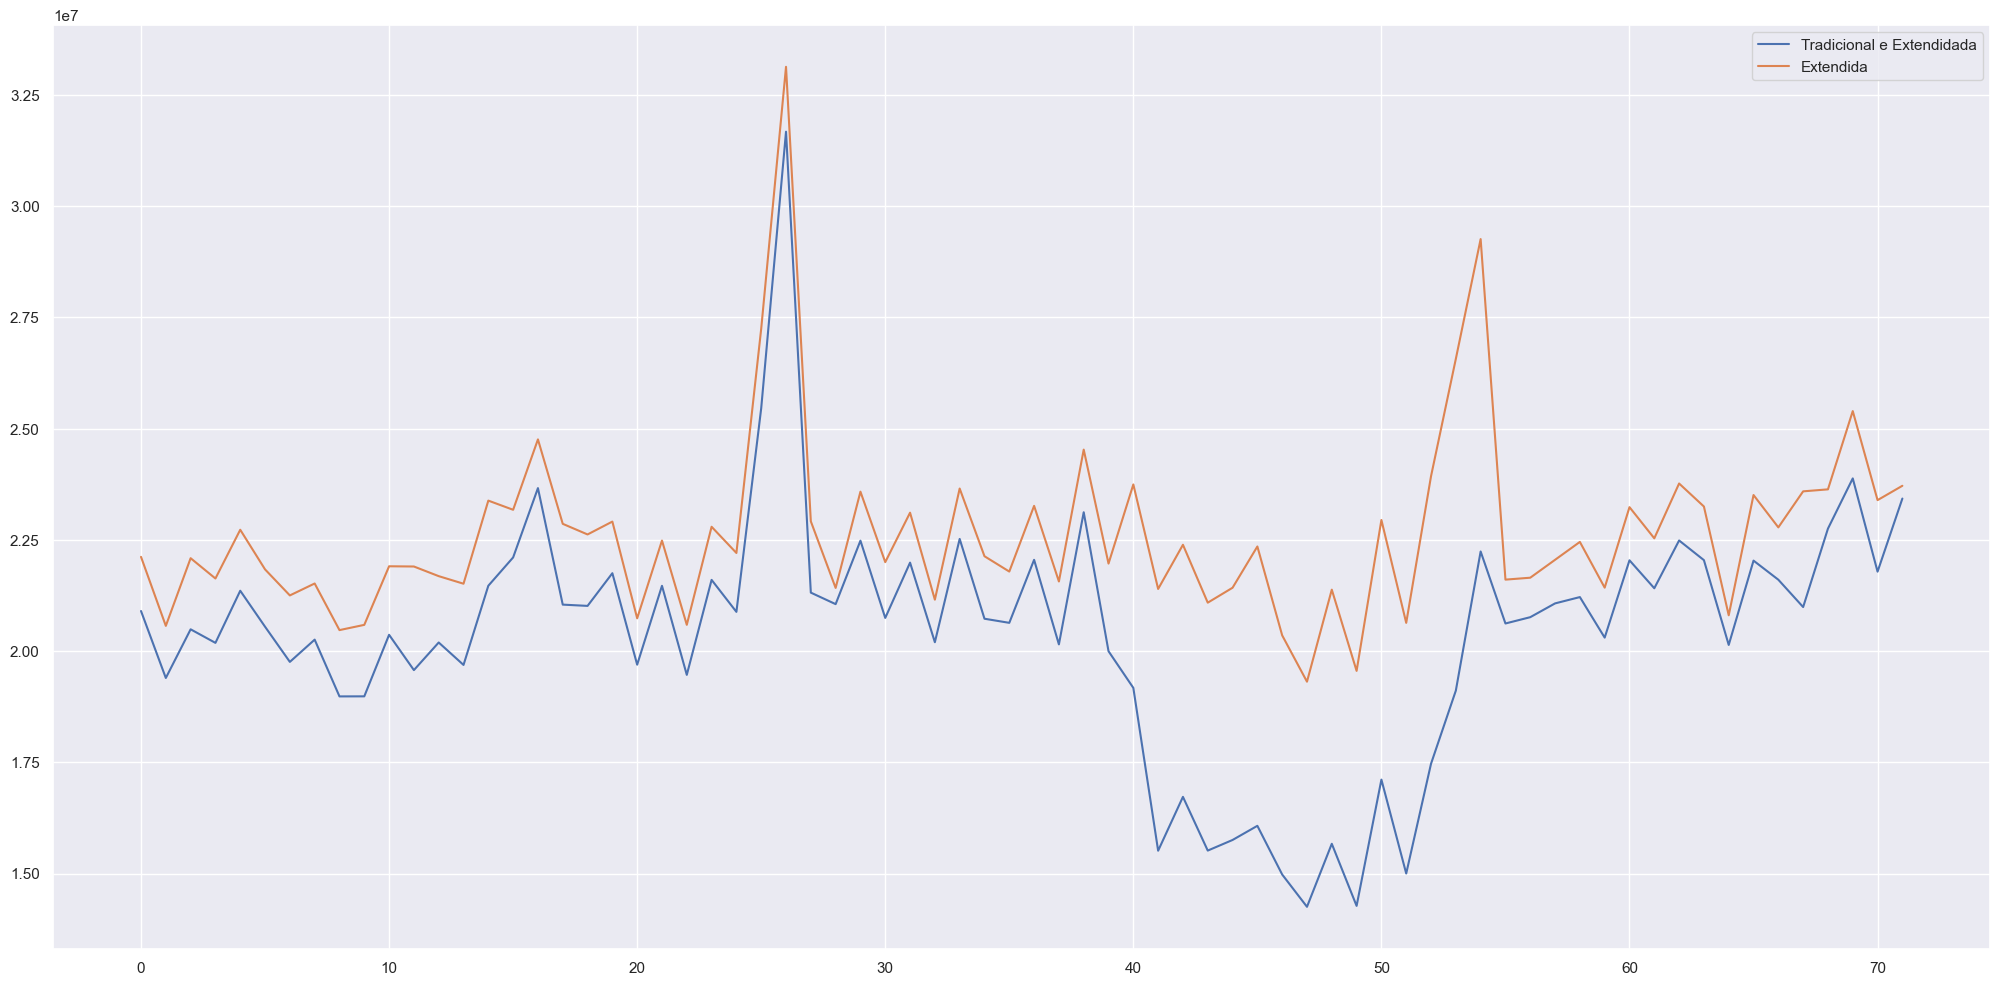

In [45]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendidada', 'Extendida'])

### H7. Lojas abertas durante o Natal deveriam vender mais.
**FALSA** Lojas abertas durante o NATAL vendem menos.

<AxesSubplot: xlabel='year', ylabel='sales'>

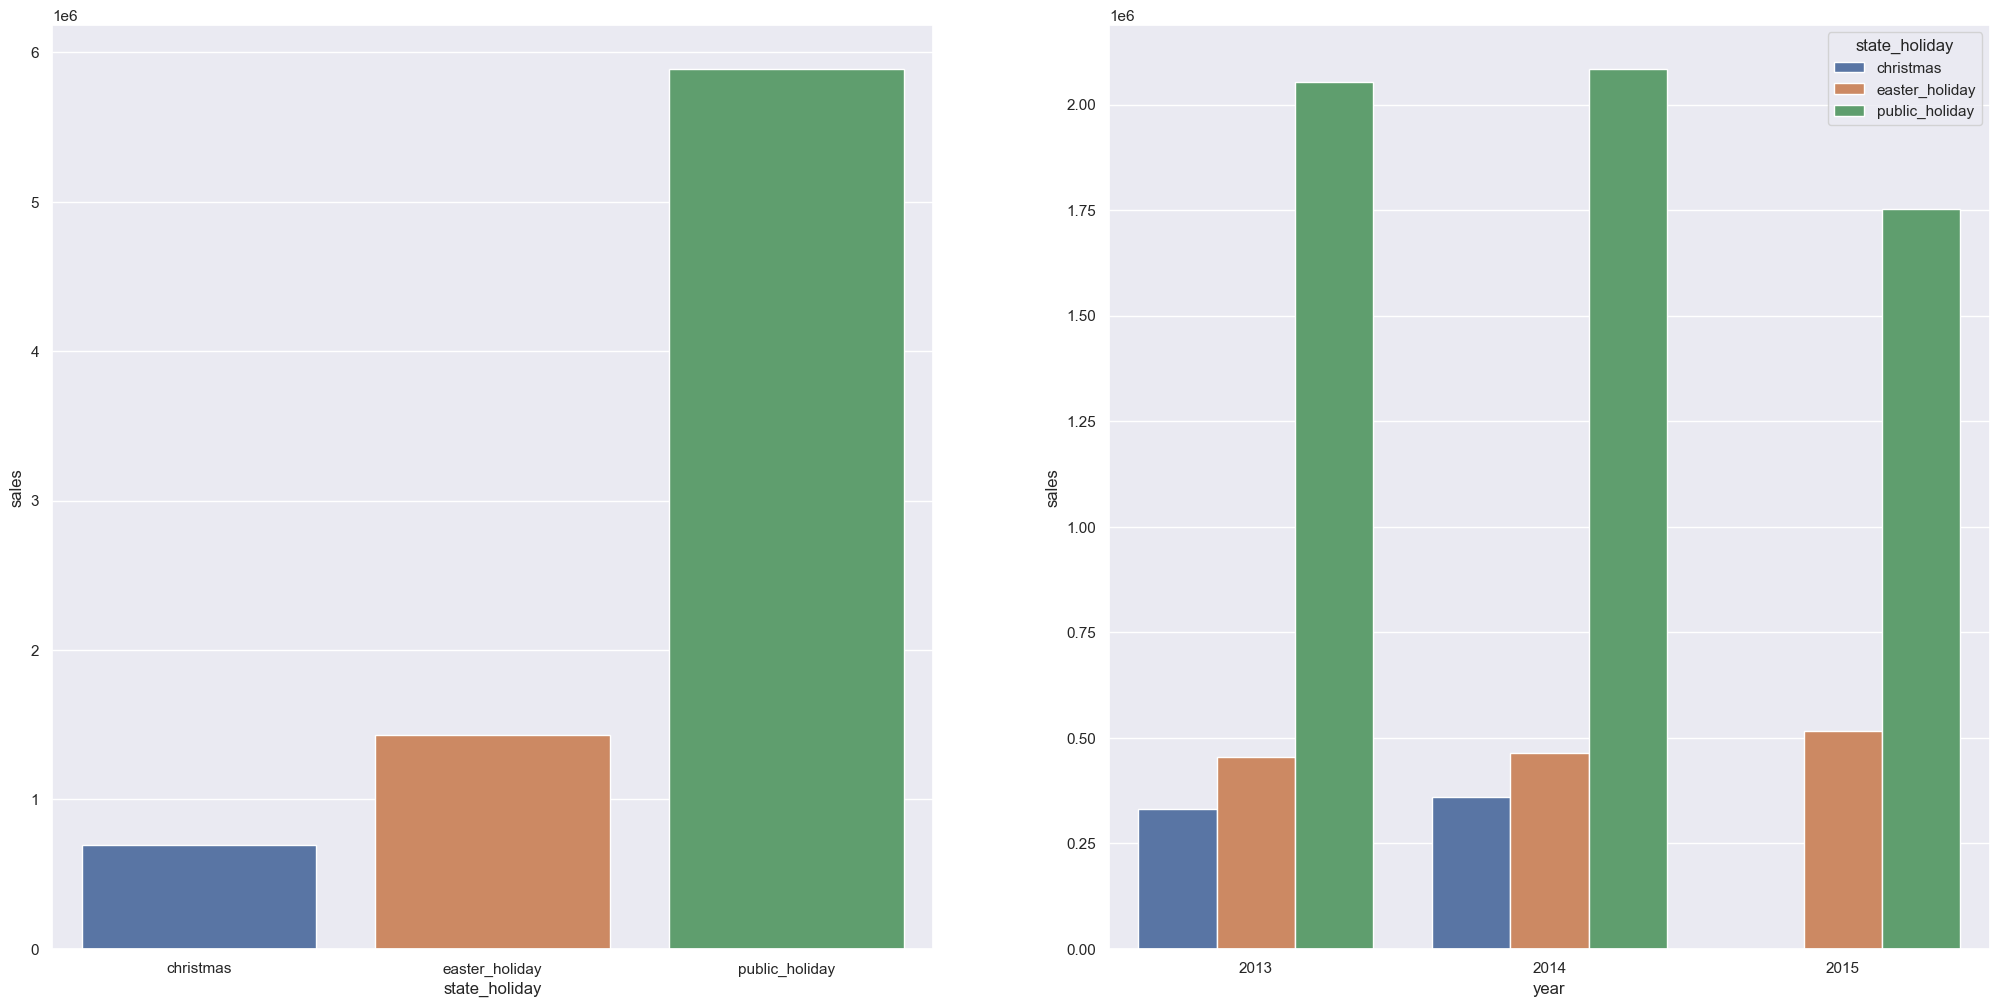

In [46]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

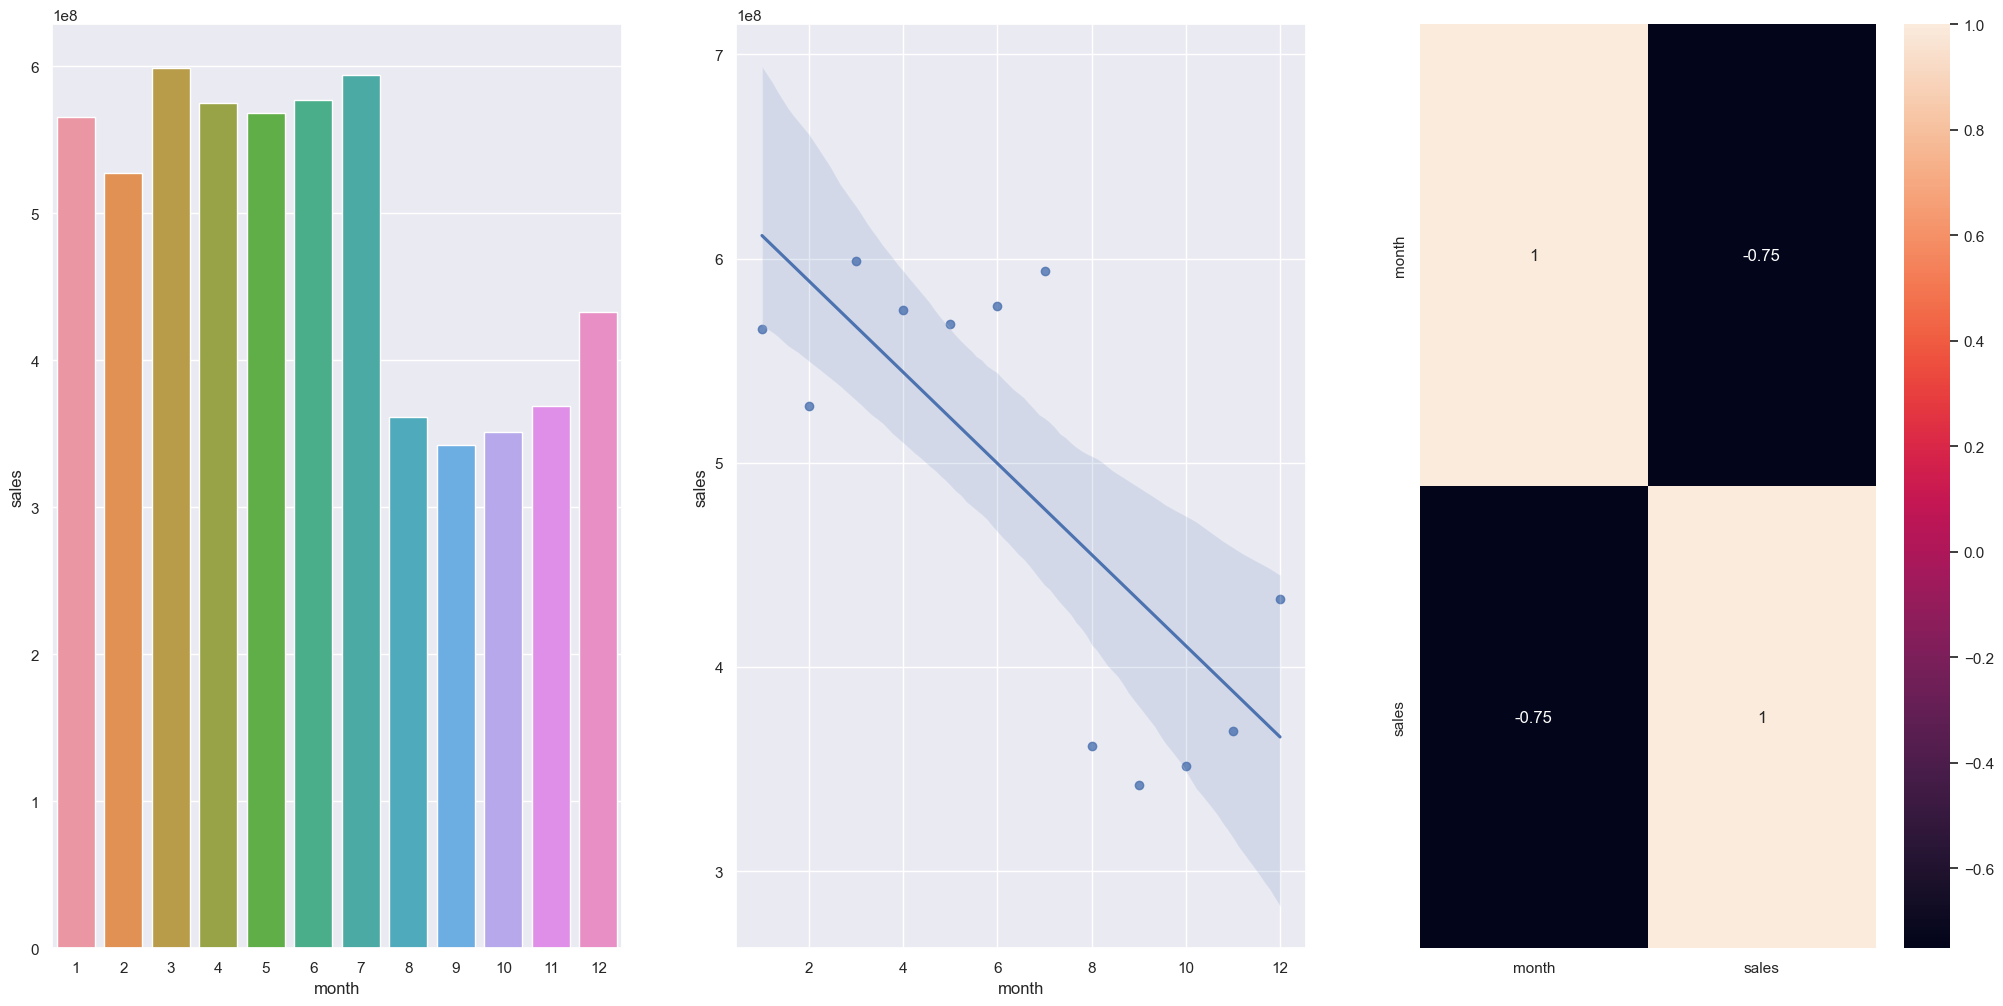

In [47]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem MENOS ao longo dos anos

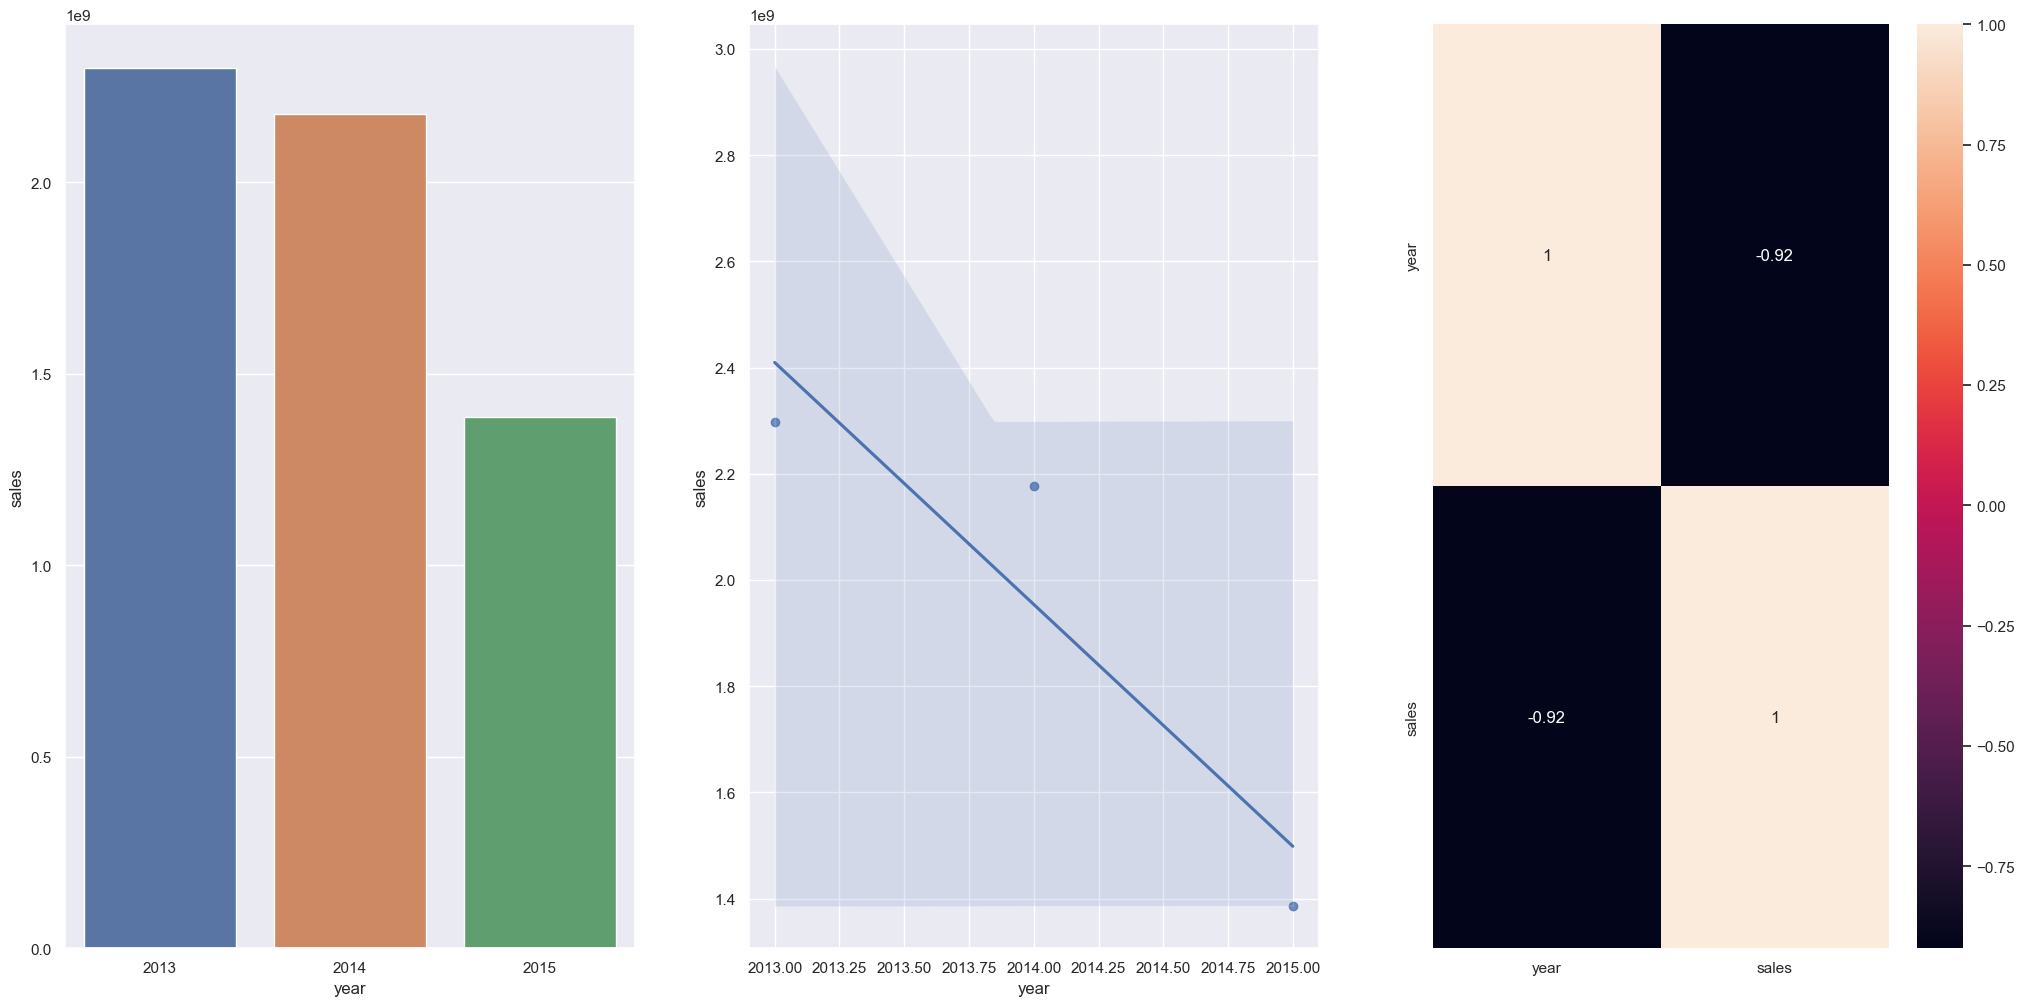

In [48]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas que abrem segundo semestre deveriam vender mais.
**FALSA** Lojas vendem MENOS no segundo semestre.

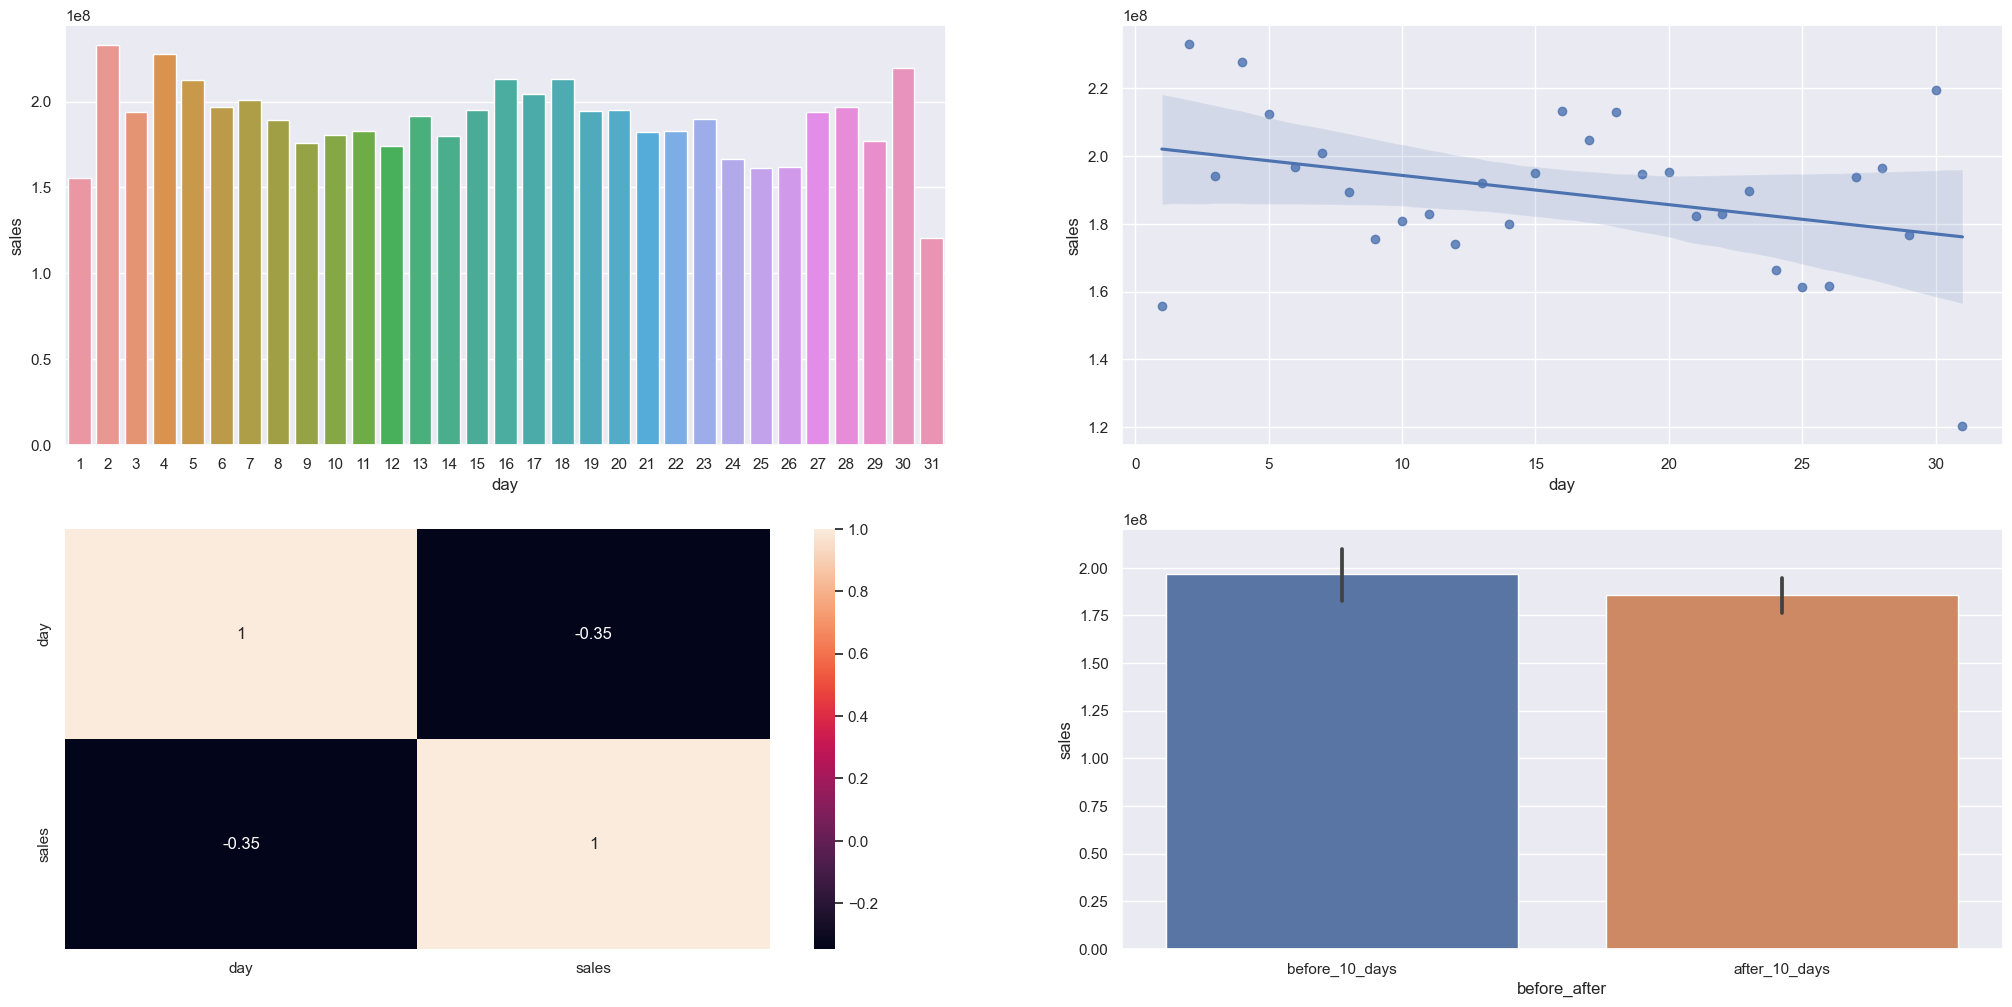

In [49]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux1);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem MAIS depois do dia 10.

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem MENOS aos finais de semana.

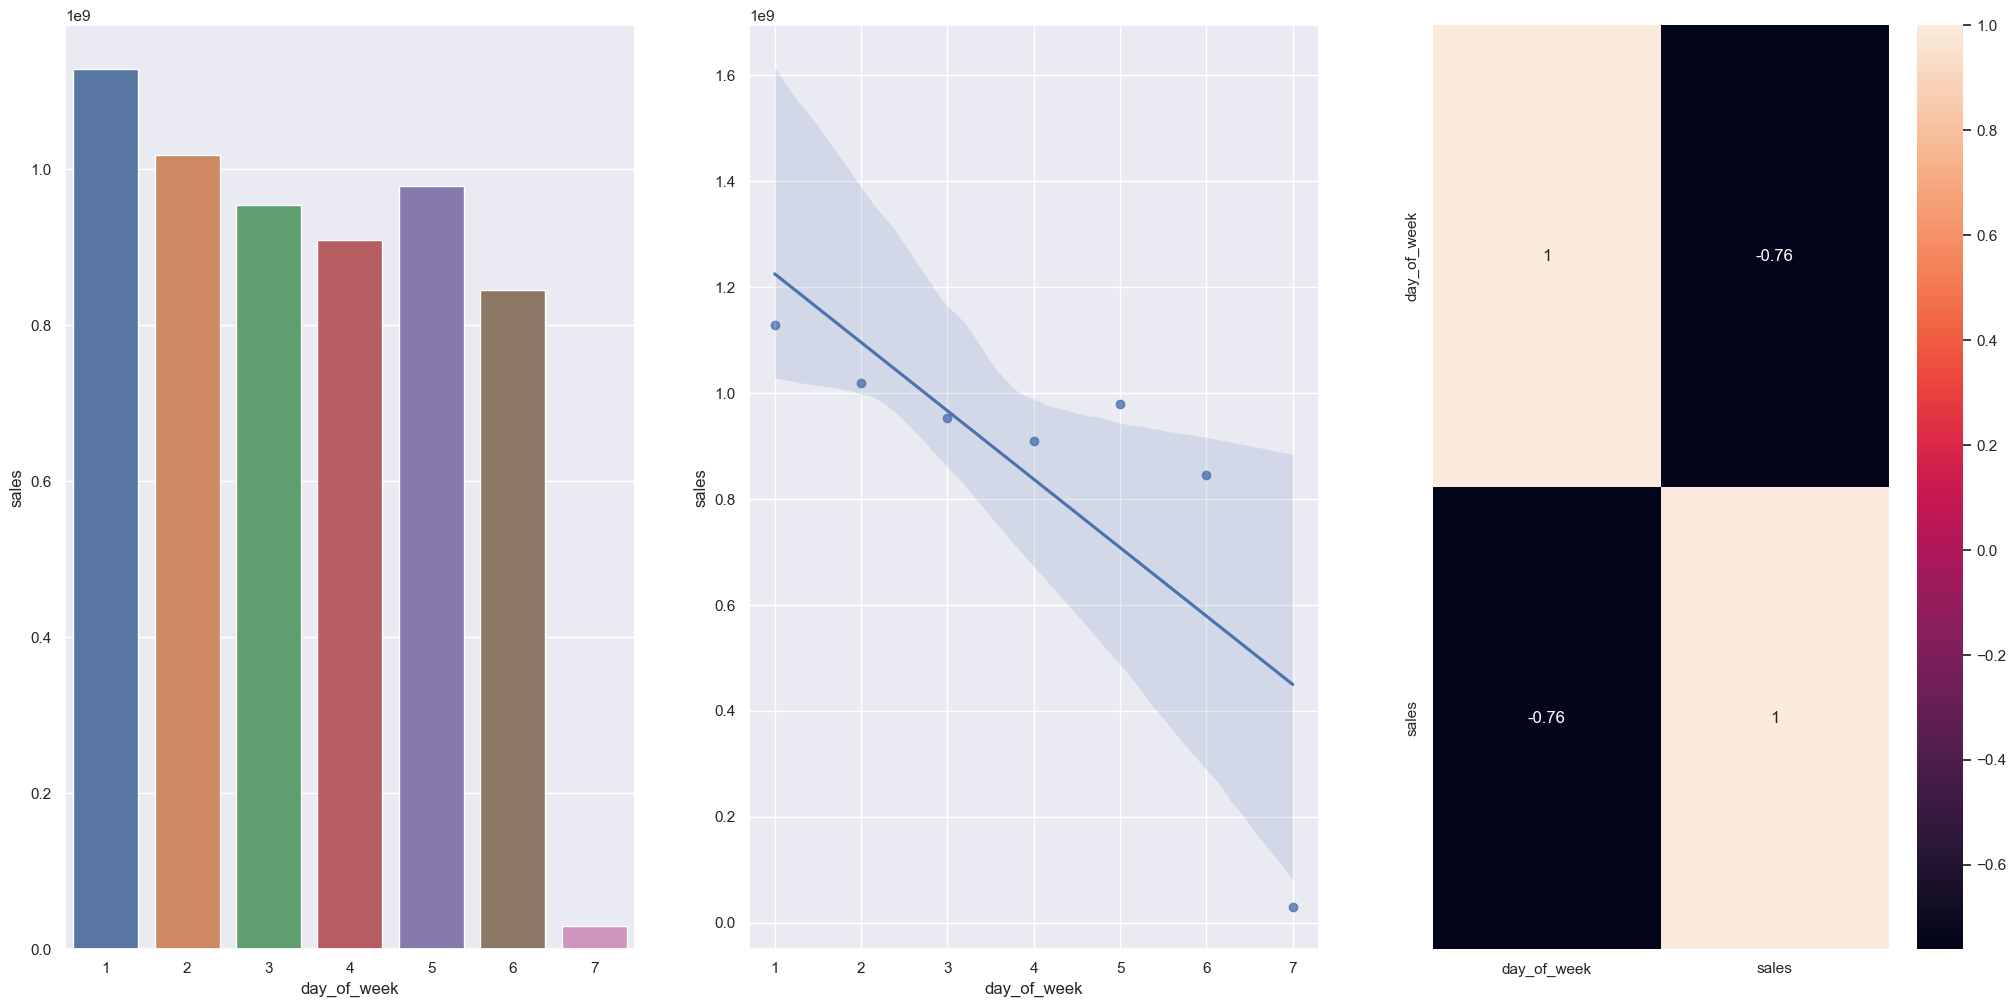

In [50]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durantes os feriados escolares.
**VERDADEIRA** Lojas vendem MENOS durante os feriados escolares, execto Julho e Agosto.

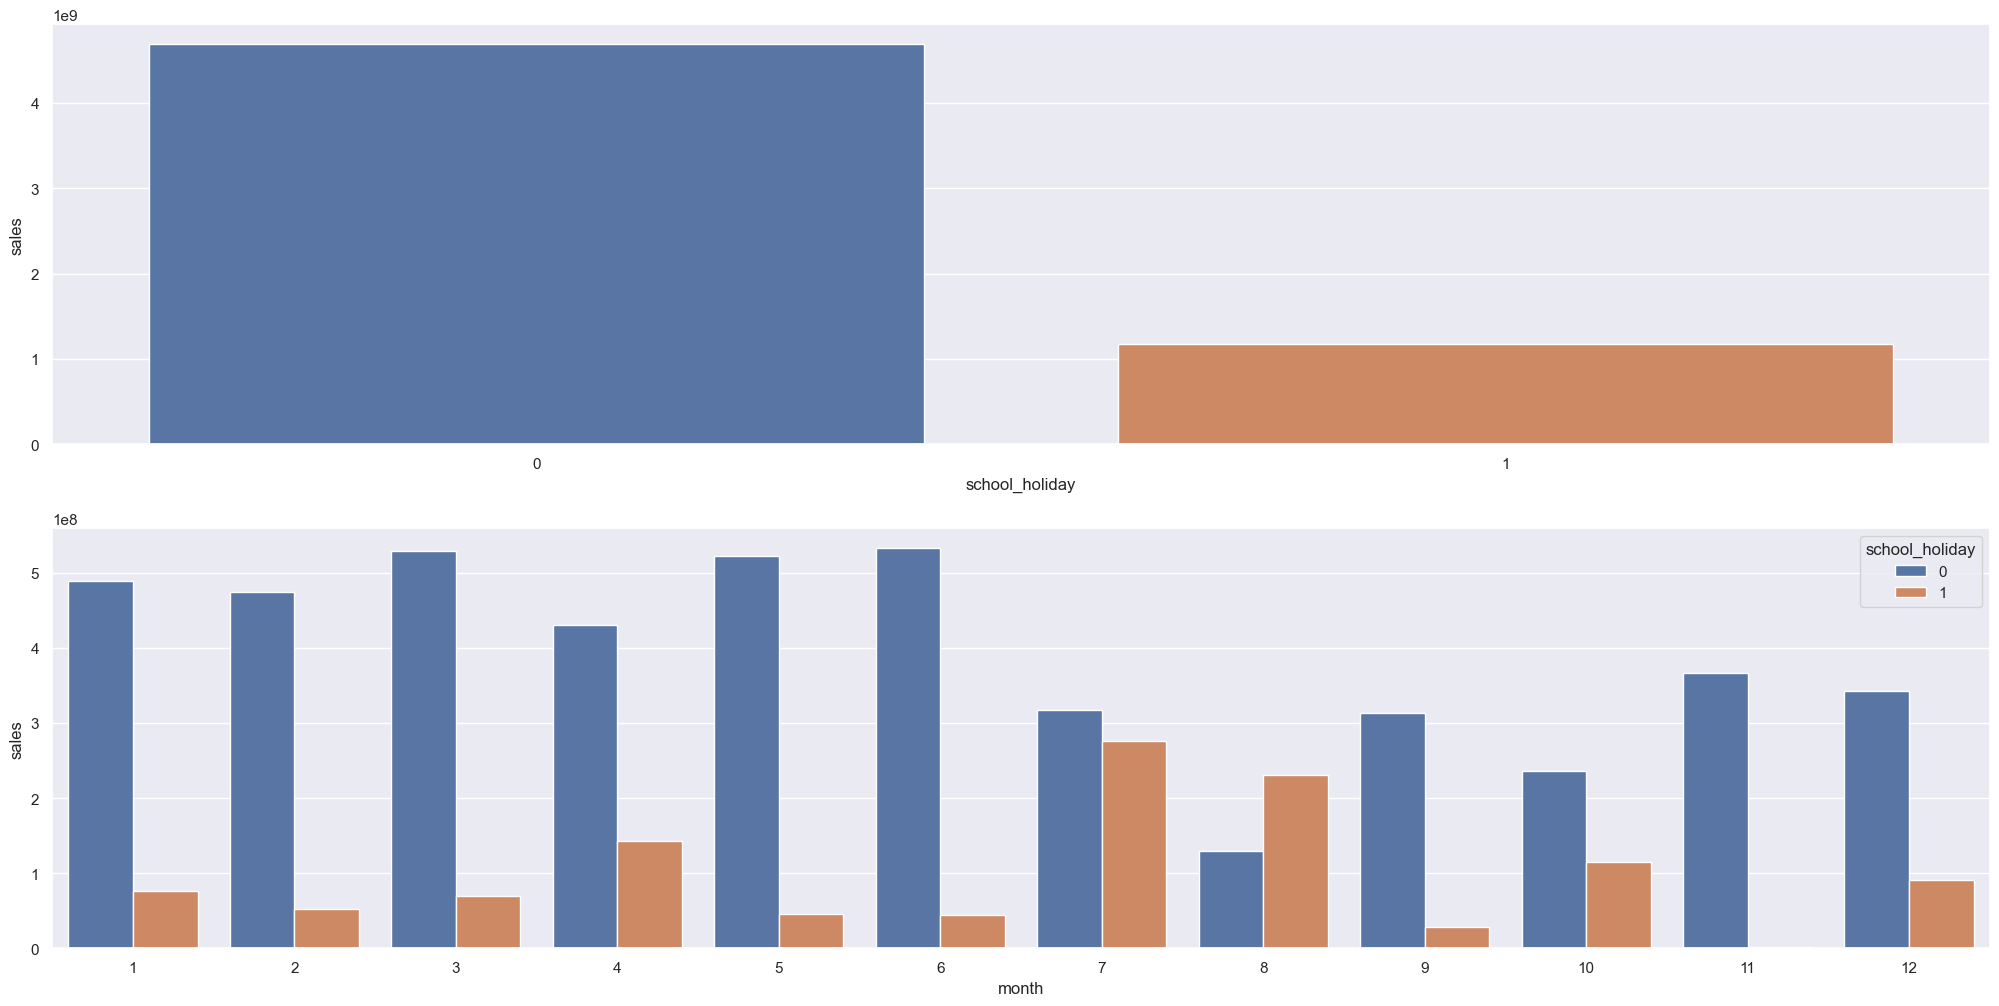

In [51]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);


### 4.2.1 Resumo das Hipoteses

In [52]:
from tabulate import tabulate

In [53]:
tab = [['Hipóteses', 'Conclusão', 'Relevânica'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
       ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevânica
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

<AxesSubplot: >

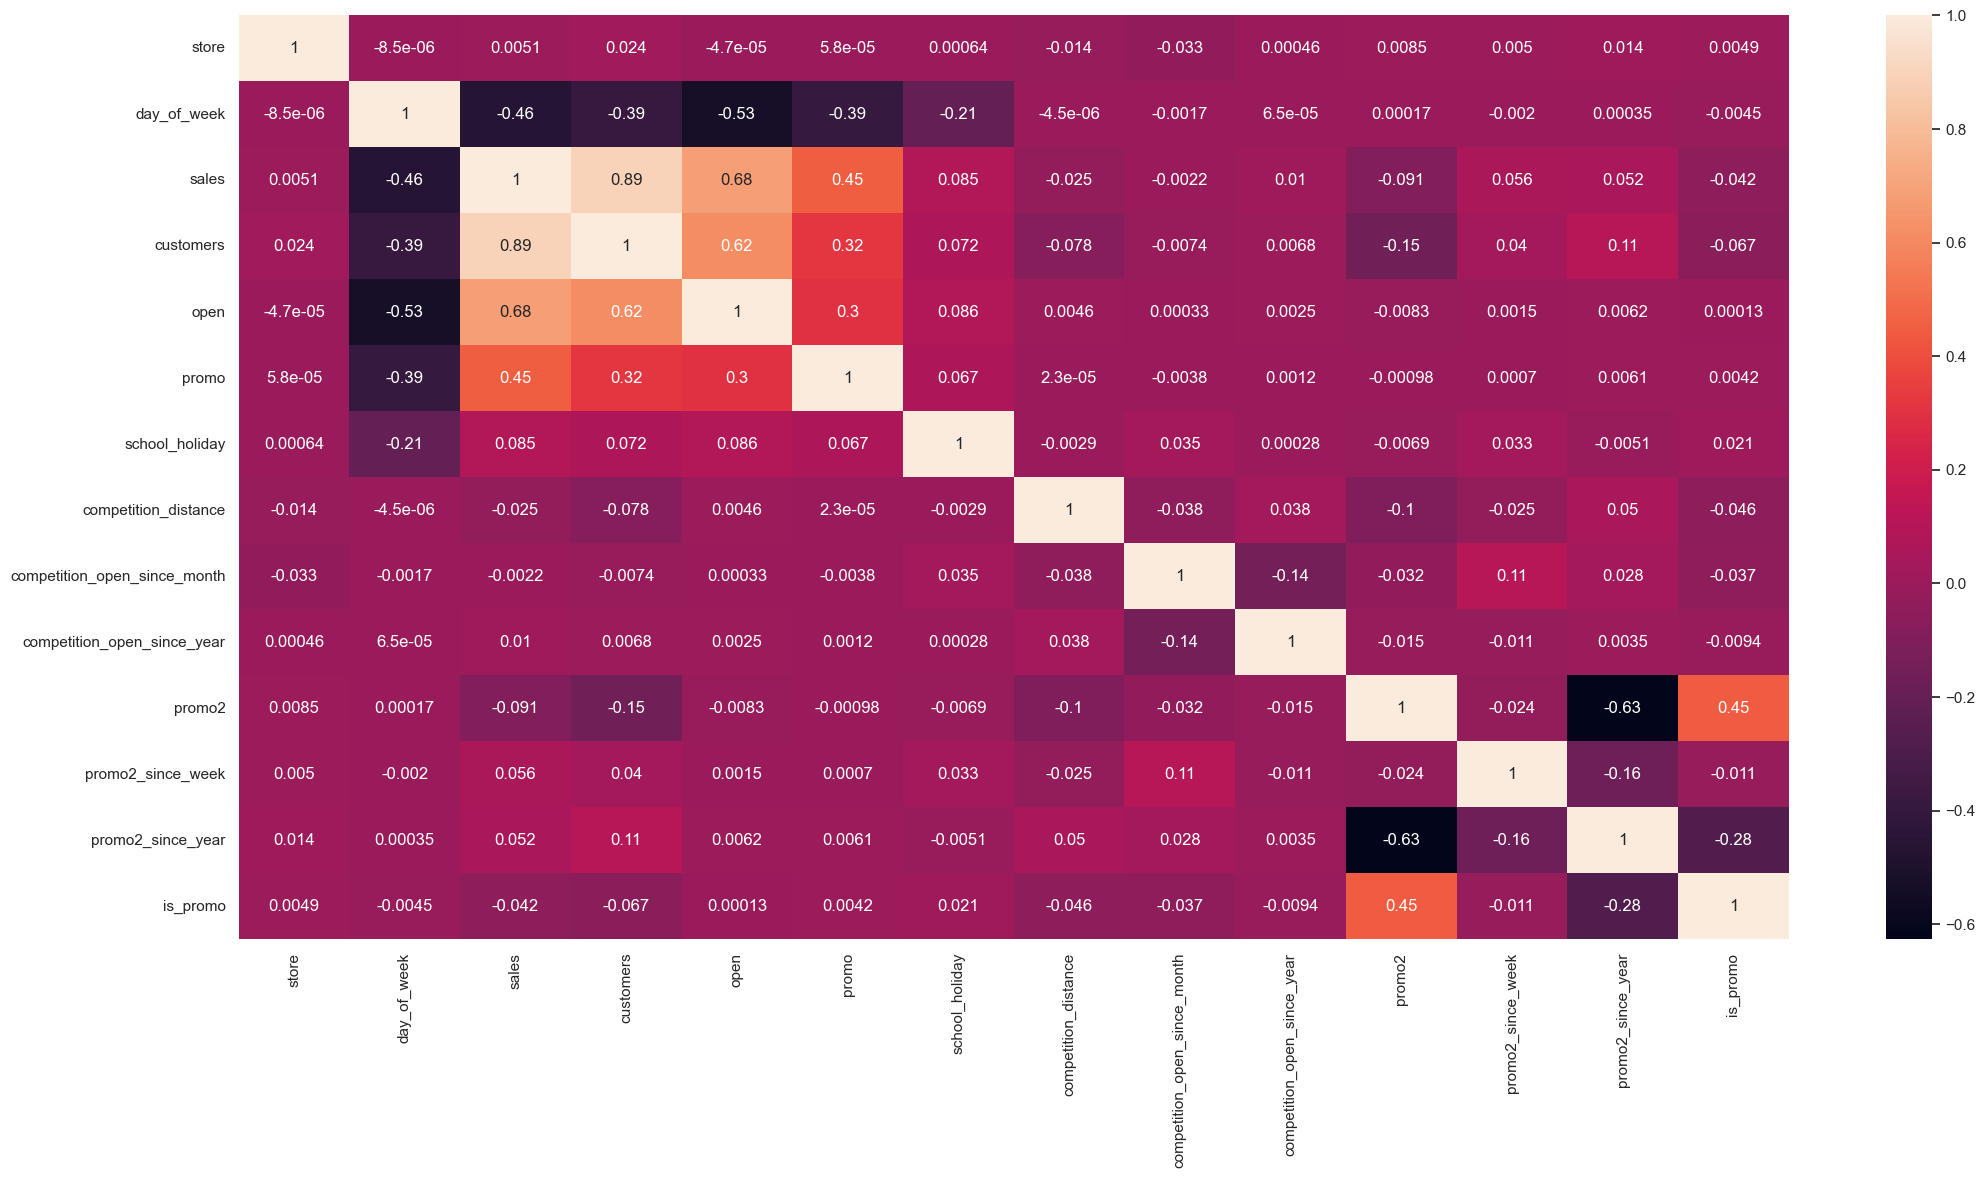

In [54]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True)

### 4.3.2. Categorical Attributes

<AxesSubplot: >

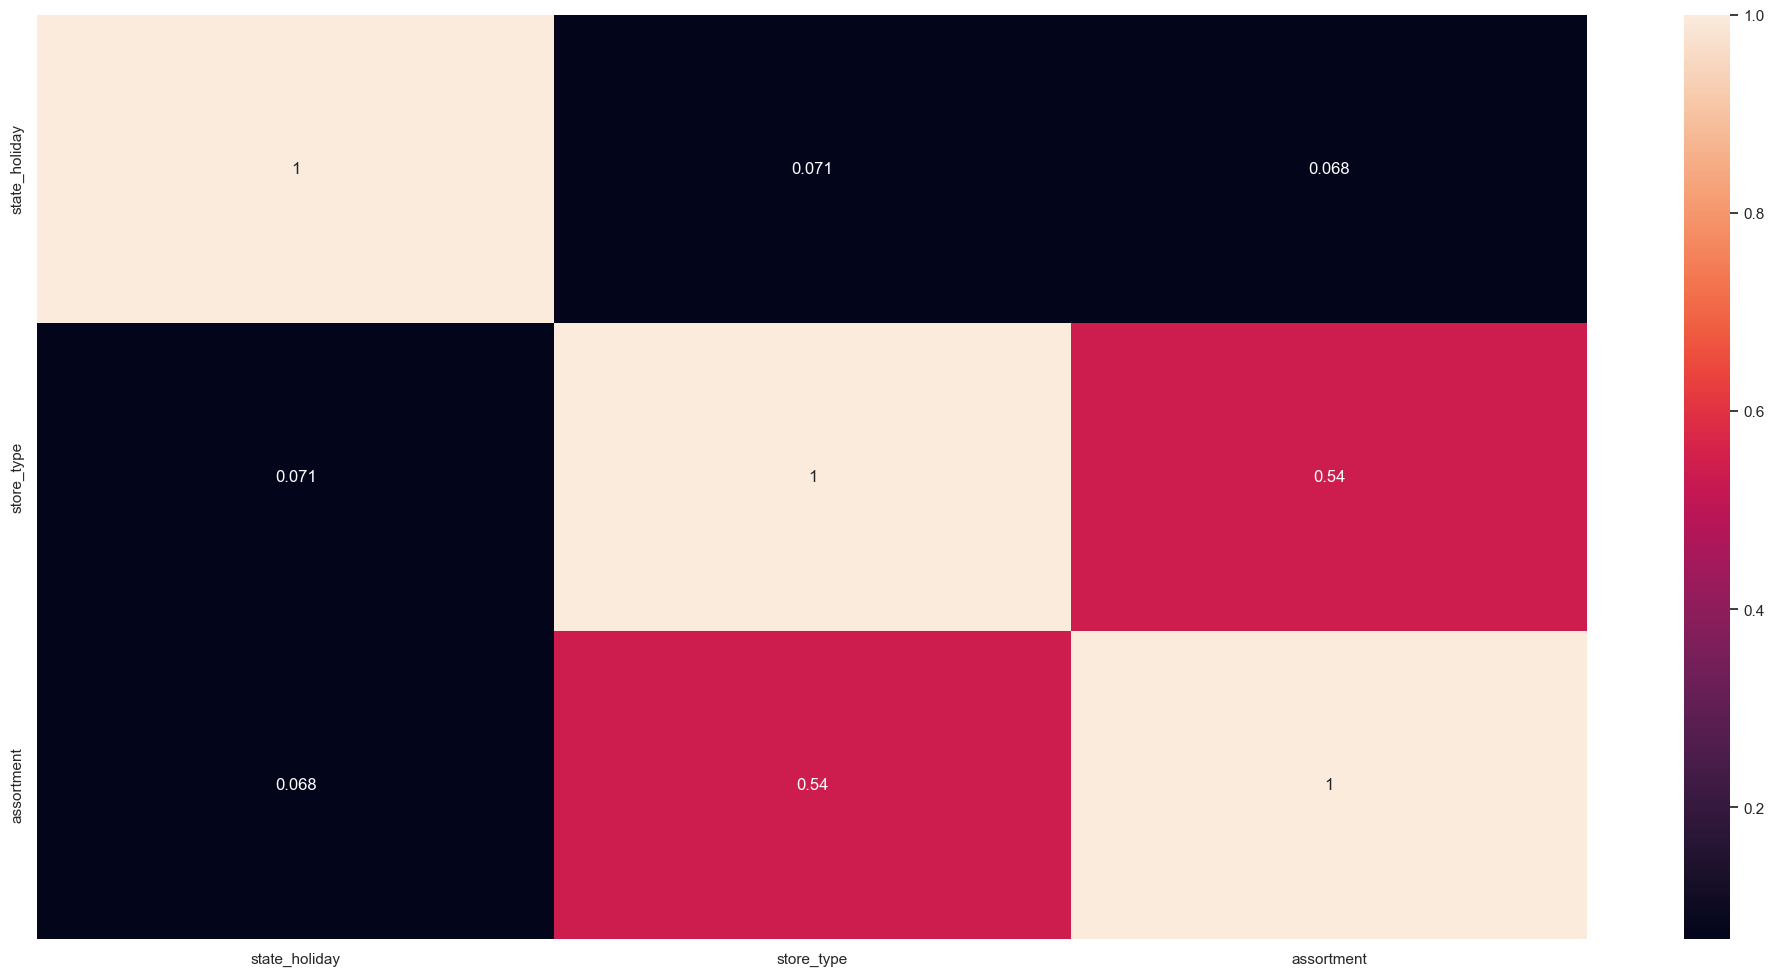

In [55]:
#only categorical data
a = df4.select_dtypes(include='object')

#calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


#final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

In [56]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

# 5.0. DATA PREPARATION

In [58]:
df5 = df4.copy()

## <s> 5.1. Normalização </s>

## 5.2. Rescaling

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


## 5.3. Transformação

### 5.3.1. Encoding

In [60]:
#state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment -Ordinal Encoding
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Responde Variable Transformation

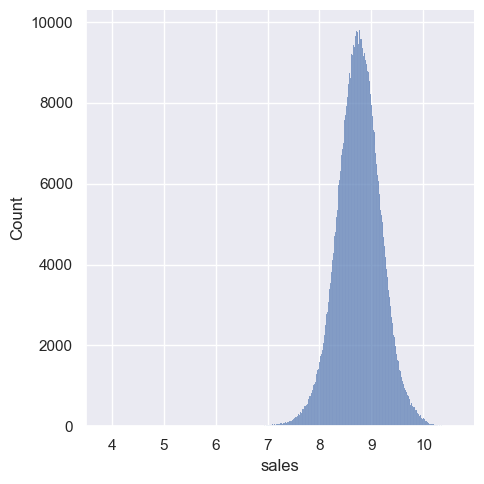

In [61]:
df5['sales'] = np.log1p(df5['sales'])
sns.displot(df5['sales'])

### 5.3.3. Nature Transformation

In [62]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2 * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2 * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2 * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2 * np.pi/52)))

In [63]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.171244,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.931507,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.284330,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.068493,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.906300,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.219178,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.276252,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.753425,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.455574,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.164384,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. SELEÇÃO DE ATRIBUTOS

In [64]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [65]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.171244,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.931507,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.284330,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.068493,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.906300,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.219178,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.276252,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.753425,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.455574,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.164384,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [66]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [67]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

In [68]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [69]:
df6['store_type'] = df6['store_type'].astype('int64')
df6.dtypes

store                                    int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
competition_time_month                 float64
promo_time_week                        float64
state_holiday_christmas                  uint8
state_holiday_easter_holiday             uint8
state_holiday_public_holiday             uint8
state_holiday_regular_day                uint8
day_of_week_s

In [70]:
#training dataset
#X_train = df6[df6['date'] < '2015-06-19']
#y_train = X_train['sales']

#test dataset
#X_teste = df6[df6['date'] > '2015-06-19']
#y_teste = X_teste['sales']

#print('Training Min Date: {}'.format(X_train['date'].min()))
#print('Training Max Date: {}'.format(X_train['date'].max()))

#print('\nTest Min Date: {}'.format(X_teste['date'].min()))
#print('Test Max Date: {}'.format(X_teste['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [71]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-2 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [72]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
 
#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [73]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_of_year_cos',
    'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']

#final feature
cols_selected_boruta.extend(feat_to_add)

In [74]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']